### Installing and Importing Dependencies

In [ ]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.4 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from google.colab import drive
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Sampler
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import time
import os
import copy
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve,
    precision_recall_curve, auc
)
from sklearn.preprocessing import label_binarize
import random


os.environ["OMP_NUM_THREADS"] = "1"

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models/"

### Classical CNN Model Construction and General Methods

In [ ]:
class NormalModel(nn.Module):
  def __init__(self, freeze, num_classes, device='cuda'):
        super(NormalModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
class TwoClassImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)

        self.class_to_idx = {
            'anormal': 0,
            'bsuspectglaucoma': 1,
            'cglaucoma': 1
        }

    def __getitem__(self, index):
        # Get original image and label
        path, original_target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            sample = self.transform(sample)

        target_class_name = self.classes[original_target]
        target = self.class_to_idx[target_class_name]

        return sample, target

In [ ]:
def load_data(batch_size, dataset, PAPILA_dual_class=False):

  train_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])

  valid_test_transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])


  if dataset == 'APTOS':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/APTOS2019/"

  elif dataset == "IDRID":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/IDRID_images/"

  elif dataset == "Messidor":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/MESSIDOR2/"

  elif dataset == "GlaucomaFundus":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/Glaucoma_fundus/"

  elif dataset == "PAPILA":
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA/"

    if PAPILA_dual_class:
      train_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
      val_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'val'), transform=valid_test_transform)
      test_dataset = TwoClassImageFolder(root=os.path.join(data_dir, 'test'), transform=valid_test_transform)

    else:
      train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
      val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
      test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader, test_loader


  elif dataset == 'G1020':
    data_dir = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/G1020/"


  train_dataset = datasets.ImageFolder(root=data_dir + 'train', transform=train_transform)
  val_dataset = datasets.ImageFolder(root=data_dir + 'val', transform=valid_test_transform)
  test_dataset = datasets.ImageFolder(root=data_dir + 'test', transform=valid_test_transform)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
  valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

  return train_loader, valid_loader, test_loader

### Hybrid Quantum-classical Neural Network Construction

In [ ]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 4              # Number of samples for each training step
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
@qml.qnode(dev)
def quantum_net(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

In [ ]:
class DressedQuantumNet(nn.Module):

    def __init__(self, q_depth, num_classes):

        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, num_classes)

    def forward(self, input_features):


        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = torch.hstack(quantum_net(elem, self.q_params)).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.post_net(q_out)

In [ ]:
class QuantumHybridModel(nn.Module):
  def __init__(self, q_depth, freeze, num_classes, device='cuda'):
        super(QuantumHybridModel, self).__init__()

        weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
        self.model = torchvision.models.resnet18(weights=weights)

        if freeze:
          for param in self.model.parameters():
              param.requires_grad = False

        self.model.fc = DressedQuantumNet(q_depth, num_classes)

        self.model = self.model.to(device)

  def forward(self, x):
        return self.model(x)

### General Training, Validation, Testing Functions

In [ ]:
import torchvision
from torchvision import datasets, transforms

In [ ]:
def train_model(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_probs = []

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        probs = torch.softmax(outputs, dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())



    avg_train_loss = train_loss / len(train_loader.dataset)
    accuracy = correct / total * 100

    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_train_loss, accuracy, avg_auroc

In [ ]:
def validate_model(model, valid_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader.dataset)
    accuracy = correct / total * 100
    aurocs = []
    for i in range(probs.shape[1]):
        try:
            auroc = roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probs])
            aurocs.append(auroc)
        except ValueError:
            aurocs.append(0)

    avg_auroc = sum(aurocs) / len(aurocs)

    return avg_val_loss, accuracy, avg_auroc

In [ ]:
def train_validate_model(n_epochs, model, model_name, train_loader, valid_loader, seed):

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

  def adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max):
        if epoch < lr_warmup_epochs:
            lr = lr_max * (epoch + 1) / lr_warmup_epochs
        else:
            lr = lr_max
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

  scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs - 10, eta_min=1e-6)

  best_val_auc = float('-inf')
  best_model_weights = model.state_dict()
  epochs_without_improvement = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []
  train_aucs = []
  val_aucs = []

  lr_max = 5e-4
  lr_warmup_epochs = 10

  for epoch in range(n_epochs):
      print(f'Epoch [{epoch+1}/{n_epochs}]')

      adjust_learning_rate(optimizer, epoch, lr_warmup_epochs, lr_max)

      train_loss, train_accuracy, train_auroc = train_model(model, train_loader, optimizer, criterion)
      val_loss, val_accuracy, val_auroc = validate_model(model, valid_loader, criterion)


      print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Training AUROC: {train_auroc:.4f}')
      print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%, Validation AUROC: {val_auroc:.4f}')
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)
      train_aucs.append(train_auroc)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      val_aucs.append(val_auroc)

      if epoch >= lr_warmup_epochs:
            scheduler.step()

      if val_auroc > best_val_auc:
            best_val_auc = val_auroc
            best_model_weights = model.state_dict()

  model.load_state_dict(best_model_weights)
  torch.save(model, os.path.join(MODEL_SAVE_PATH, f'{model_name}_{seed}.pth'))
  return model, train_losses, train_accuracies, val_losses, val_accuracies, train_aucs, val_aucs

In [ ]:
def plot(quantum_loss, normal_loss, quantum_acc, normal_acc, quantum_auc, normal_auc):
  plt.style.use("seaborn")
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

  ax1.plot(quantum_loss, label="With quantum layer")
  ax1.plot(normal_loss, label="Without quantum layer")
  ax1.set_ylabel("Loss")
  ax1.set_ylim([0, 1])
  ax1.set_xlabel("Epoch")
  ax1.legend()

  ax2.plot(quantum_acc, label="With quantum layer")
  ax2.plot(normal_acc, label="Without quantum layer")
  ax2.set_ylabel("Accuracy")
  ax2.set_ylim([0, 100])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  ax2.plot(quantum_auc, label="With quantum layer")
  ax2.plot(normal_auc, label="Without quantum layer")
  ax2.set_ylabel("ROCAUC")
  ax2.set_ylim([0, 1])
  ax2.set_xlabel("Epoch")
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import torch

def test(model_hybrid, model_normal, test_loader, num_classes):
    model_hybrid.eval()
    model_normal.eval()

    all_labels = []
    all_preds_hybrid = []
    all_preds_normal = []
    all_probs_hybrid = []
    all_probs_normal = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Hybrid model predictions
            outputs_hybrid = model_hybrid(images)
            _, preds_hybrid = torch.max(outputs_hybrid, 1)
            probs_hybrid = torch.softmax(outputs_hybrid, dim=1)  # Probability for each class

            # Normal model predictions
            outputs_normal = model_normal(images)
            _, preds_normal = torch.max(outputs_normal, 1)
            probs_normal = torch.softmax(outputs_normal, dim=1)  # Probability for each class

            all_labels.extend(labels.cpu().numpy())
            all_preds_hybrid.extend(preds_hybrid.cpu().numpy())
            all_preds_normal.extend(preds_normal.cpu().numpy())
            all_probs_hybrid.extend(probs_hybrid.cpu().numpy())
            all_probs_normal.extend(probs_normal.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs_hybrid = np.array(all_probs_hybrid)
    all_probs_normal = np.array(all_probs_normal)

    # Calculate accuracy
    accuracy_hybrid = accuracy_score(all_labels, all_preds_hybrid)
    accuracy_normal = accuracy_score(all_labels, all_preds_normal)

    # Calculate F1 Score
    f1_hybrid = f1_score(all_labels, all_preds_hybrid, average='weighted')
    f1_normal = f1_score(all_labels, all_preds_normal, average='weighted')

    print(f'Hybrid Model Accuracy: {accuracy_hybrid * 100:.2f}%')
    print(f'Normal Model Accuracy: {accuracy_normal * 100:.2f}%')
    print(f'Hybrid Model F1 Score: {f1_hybrid:.4f}')
    print(f'Normal Model F1 Score: {f1_normal:.4f}')

    if num_classes == 2:  # Binary Classification
        # Extract the probabilities of the positive class (class 1)
        all_probs_hybrid_class1 = all_probs_hybrid[:, 1]
        all_probs_normal_class1 = all_probs_normal[:, 1]

        # Calculate AUC
        auc_hybrid = roc_auc_score(all_labels, all_probs_hybrid_class1)
        auc_normal = roc_auc_score(all_labels, all_probs_normal_class1)

        print(f'Hybrid Model AUC: {auc_hybrid:.4f}')
        print(f'Normal Model AUC: {auc_normal:.4f}')

        # Plot ROC curves
        fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels, all_probs_hybrid_class1)
        fpr_normal, tpr_normal, _ = roc_curve(all_labels, all_probs_normal_class1)

        plt.figure(figsize=(10, 6))
        plt.plot(fpr_hybrid, tpr_hybrid, label=f'Hybrid Model AUC = {auc_hybrid:.4f}')
        plt.plot(fpr_normal, tpr_normal, label=f'Normal Model AUC = {auc_normal:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random chance
        plt.title('ROC Curve - Hybrid and Normal Models')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()

        # Calculate and print AUPR
        precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels, all_probs_hybrid_class1)
        precision_normal, recall_normal, _ = precision_recall_curve(all_labels, all_probs_normal_class1)

        aupr_hybrid = auc(recall_hybrid, precision_hybrid)
        aupr_normal = auc(recall_normal, precision_normal)

        print(f'Hybrid Model AUPR: {aupr_hybrid:.4f}')
        print(f'Normal Model AUPR: {aupr_normal:.4f}')

        # Plot Precision-Recall curves
        plt.figure(figsize=(10, 6))
        plt.plot(recall_hybrid, precision_hybrid, label=f'Hybrid Model AUPR = {aupr_hybrid:.4f}')
        plt.plot(recall_normal, precision_normal, label=f'Normal Model AUPR = {aupr_normal:.4f}')
        plt.title('Precision-Recall Curve - Hybrid and Normal Models')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower left')
        plt.show()

    else:  # Multi-class Classification
        # For multi-class, handle per class ROC and PR curves
        for i in range(num_classes):
            # Calculate AUC for each class
            fpr_hybrid, tpr_hybrid, _ = roc_curve(all_labels == i, all_probs_hybrid[:, i])
            fpr_normal, tpr_normal, _ = roc_curve(all_labels == i, all_probs_normal[:, i])

            auc_hybrid = roc_auc_score(all_labels == i, all_probs_hybrid[:, i])
            auc_normal = roc_auc_score(all_labels == i, all_probs_normal[:, i])

            plt.figure(figsize=(10, 6))
            plt.plot(fpr_hybrid, tpr_hybrid, label=f'Class {i} Hybrid Model AUC = {auc_hybrid:.4f}')
            plt.plot(fpr_normal, tpr_normal, label=f'Class {i} Normal Model AUC = {auc_normal:.4f}')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title(f'ROC Curve - Class {i}')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Precision-Recall Curve
            precision_hybrid, recall_hybrid, _ = precision_recall_curve(all_labels == i, all_probs_hybrid[:, i])
            precision_normal, recall_normal, _ = precision_recall_curve(all_labels == i, all_probs_normal[:, i])

            aupr_hybrid = auc(recall_hybrid, precision_hybrid)
            aupr_normal = auc(recall_normal, precision_normal)

            plt.figure(figsize=(10, 6))
            plt.plot(recall_hybrid, precision_hybrid, label=f'Class {i} Hybrid Model AUPR = {aupr_hybrid:.4f}')
            plt.plot(recall_normal, precision_normal, label=f'Class {i} Normal Model AUPR = {aupr_normal:.4f}')
            plt.title(f'Precision-Recall Curve - Class {i}')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()


# Experiments: Training Model on PAPILA - Testing on PAPILA

In [ ]:
n_epochs = 100
num_classes = 3
q_depth = 4
batch_size = 32
dataset = "PAPILA"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'

Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 215MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7660, Training Accuracy: 68.06%, Training AUROC: 0.6131
Validation Loss: 0.4666, Validation Accuracy: 84.38%, Validation AUROC: 0.4340
Epoch [2/100]
Training Loss: 0.7687, Training Accuracy: 68.40%, Training AUROC: 0.5885
Validation Loss: 0.4755, Validation Accuracy: 84.38%, Validation AUROC: 0.4407
Epoch [3/100]
Training Loss: 0.7639, Training Accuracy: 67.71%, Training AUROC: 0.6133
Validation Loss: 0.4743, Validation Accuracy: 84.38%, Validation AUROC: 0.4537
Epoch [4/100]
Training Loss: 0.7420, Training Accuracy: 68.75%, Training AUROC: 0.6303
Validation Loss: 0.4457, Validation Accuracy: 84.38%, Validation AUROC: 0.4710
Epoch [5/100]
Training Loss: 0.7356, Training Accuracy: 67.71%, Training AUROC: 0.6865
Validation Loss: 0.4344, Validation Accuracy: 84.38%, Validation AUROC: 0.4846
Epoch [6/100]
Training Loss: 0.7383, Training Accuracy: 68.40%, Training AUROC: 0.6688
Validation Loss: 0.4463, Validation Accuracy: 82.81%, Validation AUROC: 0.5006
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9278, Training Accuracy: 56.60%, Training AUROC: 0.5270
Validation Loss: 0.7056, Validation Accuracy: 84.38%, Validation AUROC: 0.3957
Epoch [2/100]
Training Loss: 0.8945, Training Accuracy: 64.93%, Training AUROC: 0.5230
Validation Loss: 0.6231, Validation Accuracy: 84.38%, Validation AUROC: 0.4093
Epoch [3/100]
Training Loss: 0.8650, Training Accuracy: 68.40%, Training AUROC: 0.5224
Validation Loss: 0.5601, Validation Accuracy: 84.38%, Validation AUROC: 0.4574
Epoch [4/100]
Training Loss: 0.8497, Training Accuracy: 68.40%, Training AUROC: 0.5096
Validation Loss: 0.5367, Validation Accuracy: 84.38%, Validation AUROC: 0.4519
Epoch [5/100]
Training Loss: 0.8384, Training Accuracy: 68.40%, Training AUROC: 0.6203
Validation Loss: 0.5404, Validation Accuracy: 84.38%, Validation AUROC: 0.4377
Epoch [6/100]
Training Loss: 0.8251, Training Accuracy: 68.06%, Training AUROC: 0.5833
Validation Loss: 0.5482, Validation Accuracy: 84.38%, Validation AUROC: 0.4241
Epoc

<ipython-input-19-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


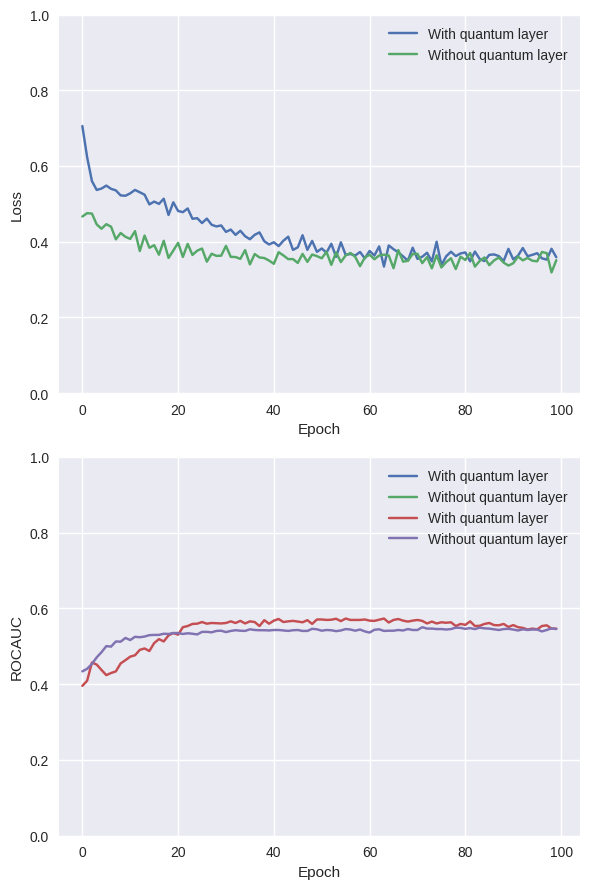

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 76.04%
Normal Model Accuracy: 77.08%
Hybrid Model F1 Score: 0.7166
Normal Model F1 Score: 0.7398
Hybrid Model AUC: 0.8395
Normal Model AUC: 0.8583


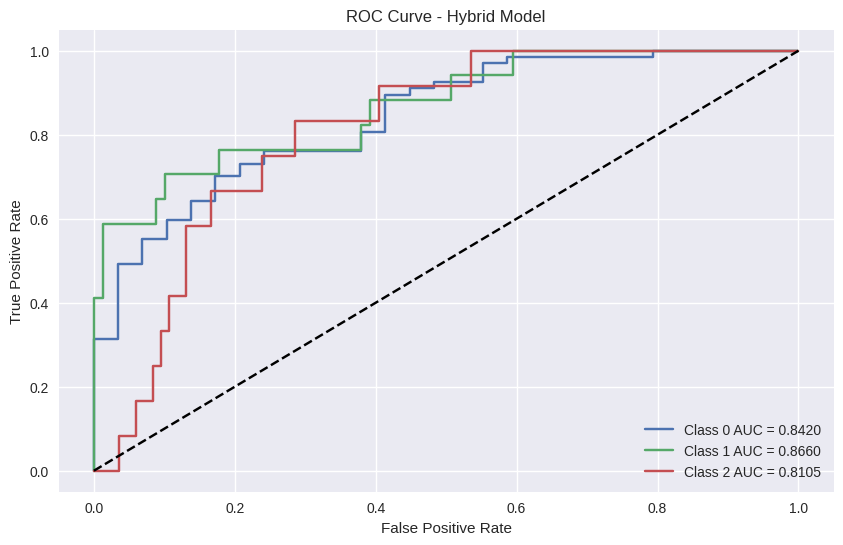

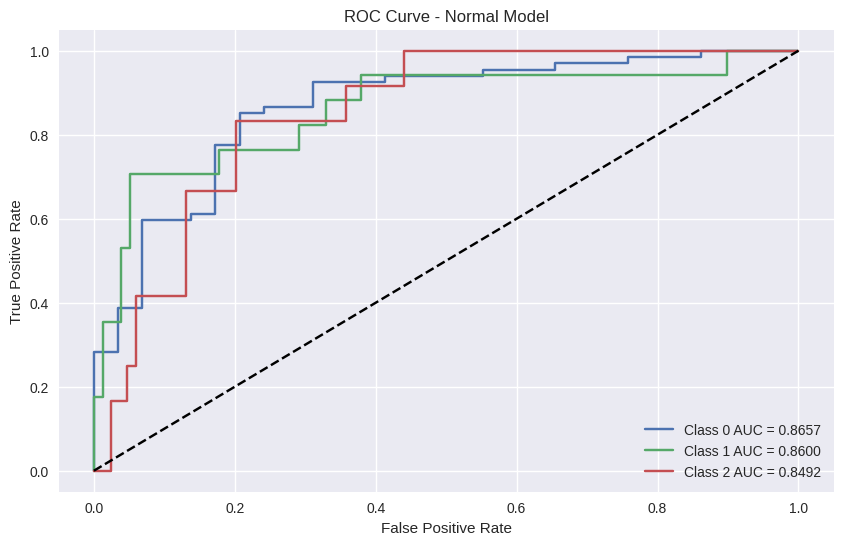

Hybrid Model AUPR: 0.6460
Normal Model AUPR: 0.6508


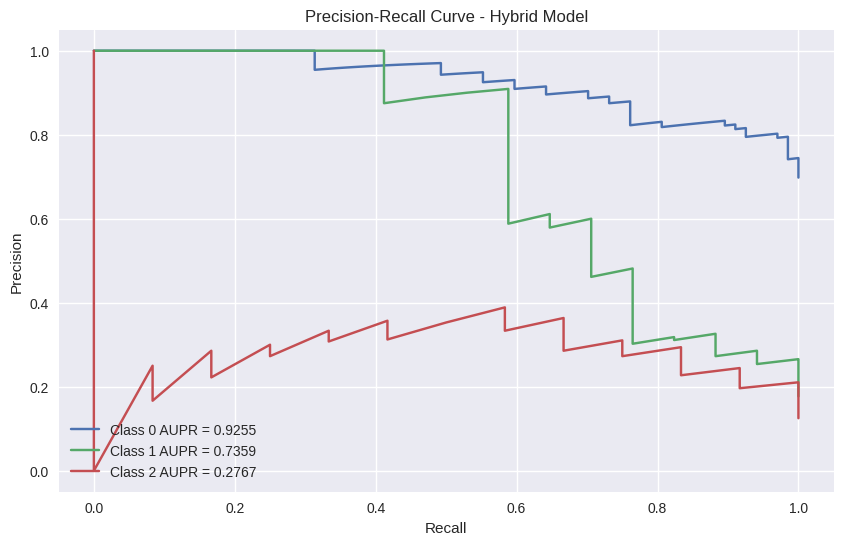

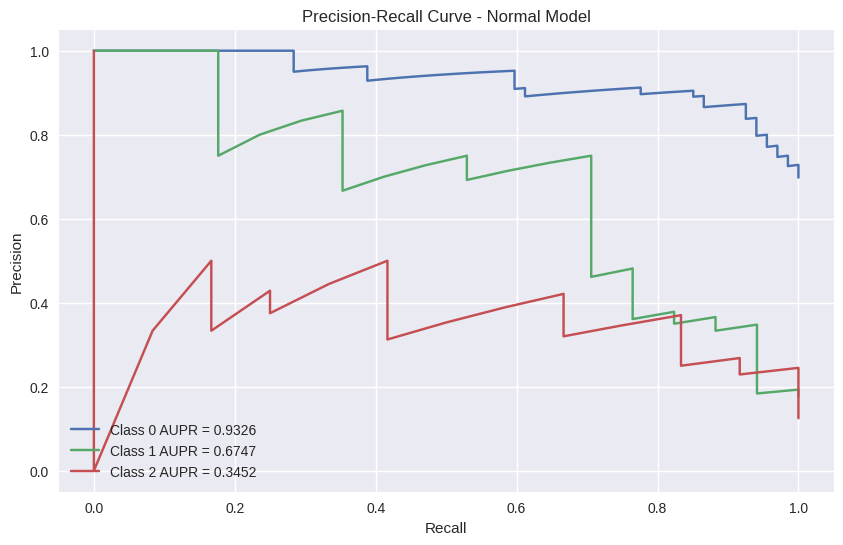

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0041, Training Accuracy: 36.11%, Training AUROC: 0.5856
Validation Loss: 0.8181, Validation Accuracy: 35.94%, Validation AUROC: 0.4117
Epoch [2/100]
Training Loss: 0.8692, Training Accuracy: 56.25%, Training AUROC: 0.5781
Validation Loss: 0.5820, Validation Accuracy: 81.25%, Validation AUROC: 0.4086
Epoch [3/100]
Training Loss: 0.7754, Training Accuracy: 68.75%, Training AUROC: 0.5746
Validation Loss: 0.4615, Validation Accuracy: 84.38%, Validation AUROC: 0.3389
Epoch [4/100]
Training Loss: 0.7750, Training Accuracy: 68.06%, Training AUROC: 0.5954
Validation Loss: 0.4464, Validation Accuracy: 84.38%, Validation AUROC: 0.3506
Epoch [5/100]
Training Loss: 0.7708, Training Accuracy: 67.36%, Training AUROC: 0.6301
Validation Loss: 0.4697, Validation Accuracy: 84.38%, Validation AUROC: 0.3840
Epoch [6/100]
Training Loss: 0.7499, Training Accuracy: 68.75%, Training AUROC: 0.6257
Validation Loss: 0.5076, Validation Accuracy: 82.81%, Validation AUROC: 0.3963
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0914, Training Accuracy: 24.65%, Training AUROC: 0.4969
Validation Loss: 1.1046, Validation Accuracy: 6.25%, Validation AUROC: 0.2389
Epoch [2/100]
Training Loss: 0.9522, Training Accuracy: 50.35%, Training AUROC: 0.4770
Validation Loss: 0.6923, Validation Accuracy: 82.81%, Validation AUROC: 0.2278
Epoch [3/100]
Training Loss: 0.8232, Training Accuracy: 67.71%, Training AUROC: 0.4884
Validation Loss: 0.5355, Validation Accuracy: 84.38%, Validation AUROC: 0.2395
Epoch [4/100]
Training Loss: 0.7710, Training Accuracy: 68.40%, Training AUROC: 0.5519
Validation Loss: 0.4929, Validation Accuracy: 84.38%, Validation AUROC: 0.2698
Epoch [5/100]
Training Loss: 0.7742, Training Accuracy: 67.71%, Training AUROC: 0.5922
Validation Loss: 0.4835, Validation Accuracy: 84.38%, Validation AUROC: 0.3062
Epoch [6/100]
Training Loss: 0.7572, Training Accuracy: 68.75%, Training AUROC: 0.6154
Validation Loss: 0.4845, Validation Accuracy: 84.38%, Validation AUROC: 0.3438
Epoch

<ipython-input-19-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


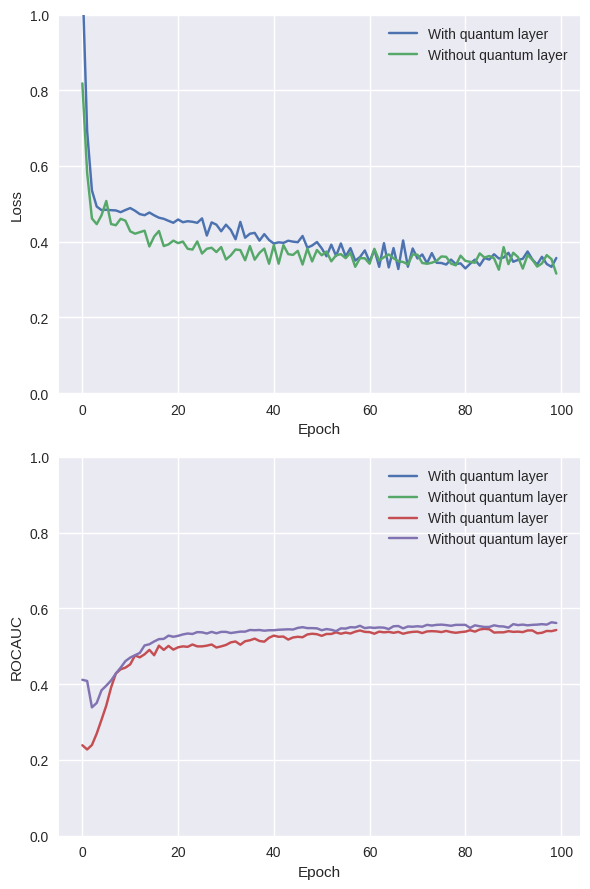

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 76.04%
Normal Model Accuracy: 78.12%
Hybrid Model F1 Score: 0.7411
Normal Model F1 Score: 0.7329
Hybrid Model AUC: 0.8178
Normal Model AUC: 0.8521


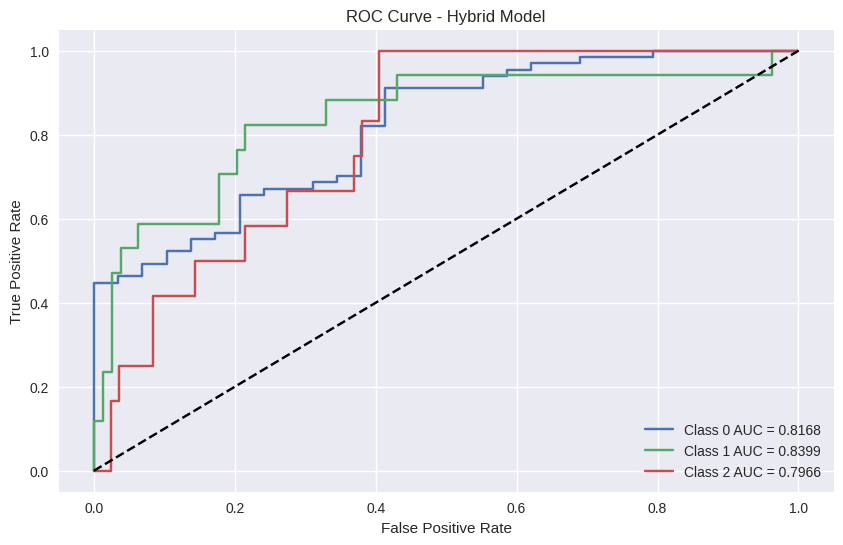

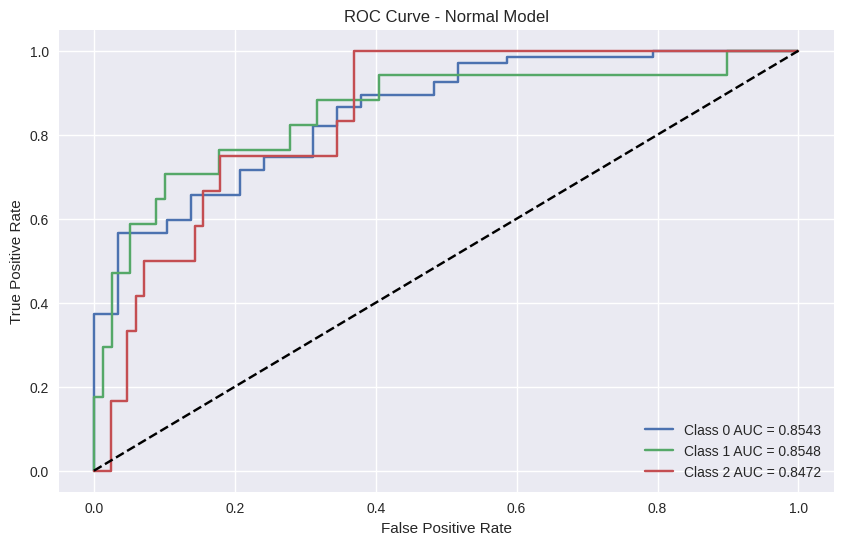

Hybrid Model AUPR: 0.6079
Normal Model AUPR: 0.6475


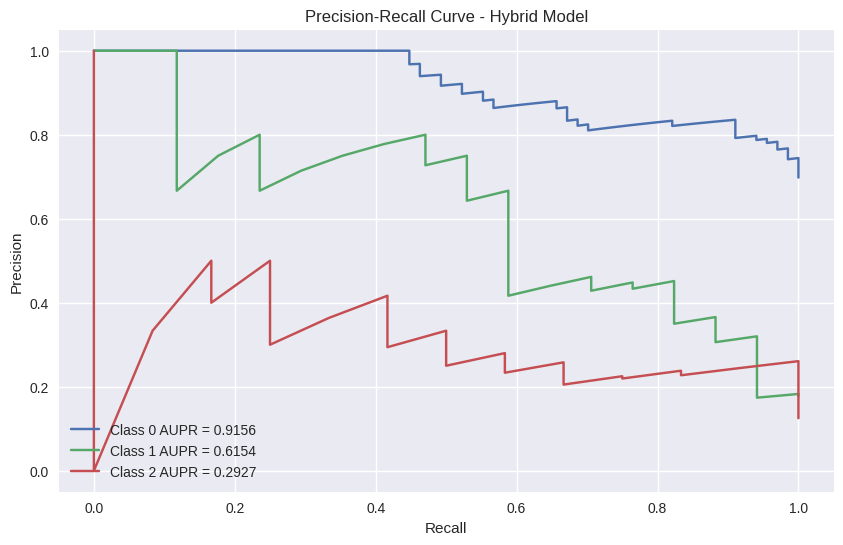

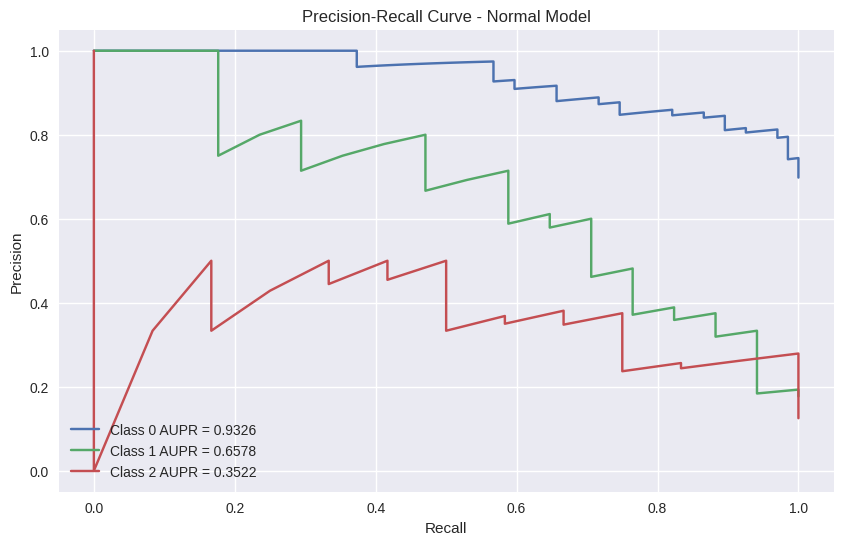

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9522, Training Accuracy: 50.35%, Training AUROC: 0.5150
Validation Loss: 0.6882, Validation Accuracy: 59.38%, Validation AUROC: 0.1321
Epoch [2/100]
Training Loss: 0.8432, Training Accuracy: 59.72%, Training AUROC: 0.5504
Validation Loss: 0.5870, Validation Accuracy: 78.12%, Validation AUROC: 0.2173
Epoch [3/100]
Training Loss: 0.8054, Training Accuracy: 67.71%, Training AUROC: 0.5221
Validation Loss: 0.5036, Validation Accuracy: 84.38%, Validation AUROC: 0.2802
Epoch [4/100]
Training Loss: 0.7634, Training Accuracy: 69.44%, Training AUROC: 0.5749
Validation Loss: 0.4972, Validation Accuracy: 84.38%, Validation AUROC: 0.3198
Epoch [5/100]
Training Loss: 0.7463, Training Accuracy: 69.10%, Training AUROC: 0.6083
Validation Loss: 0.5010, Validation Accuracy: 84.38%, Validation AUROC: 0.3630
Epoch [6/100]
Training Loss: 0.7544, Training Accuracy: 68.75%, Training AUROC: 0.6106
Validation Loss: 0.5134, Validation Accuracy: 84.38%, Validation AUROC: 0.3932
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.9236, Training Accuracy: 66.67%, Training AUROC: 0.5673
Validation Loss: 0.8123, Validation Accuracy: 53.12%, Validation AUROC: 0.3741
Epoch [2/100]
Training Loss: 0.9135, Training Accuracy: 69.44%, Training AUROC: 0.5544
Validation Loss: 0.7505, Validation Accuracy: 84.38%, Validation AUROC: 0.4173
Epoch [3/100]
Training Loss: 0.8999, Training Accuracy: 67.71%, Training AUROC: 0.6313
Validation Loss: 0.7290, Validation Accuracy: 84.38%, Validation AUROC: 0.3975
Epoch [4/100]
Training Loss: 0.8783, Training Accuracy: 69.10%, Training AUROC: 0.6431
Validation Loss: 0.7155, Validation Accuracy: 84.38%, Validation AUROC: 0.3858
Epoch [5/100]
Training Loss: 0.8797, Training Accuracy: 68.75%, Training AUROC: 0.6000
Validation Loss: 0.7030, Validation Accuracy: 84.38%, Validation AUROC: 0.4043
Epoch [6/100]
Training Loss: 0.8661, Training Accuracy: 68.40%, Training AUROC: 0.6427
Validation Loss: 0.6921, Validation Accuracy: 84.38%, Validation AUROC: 0.4247
Epoc

<ipython-input-19-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


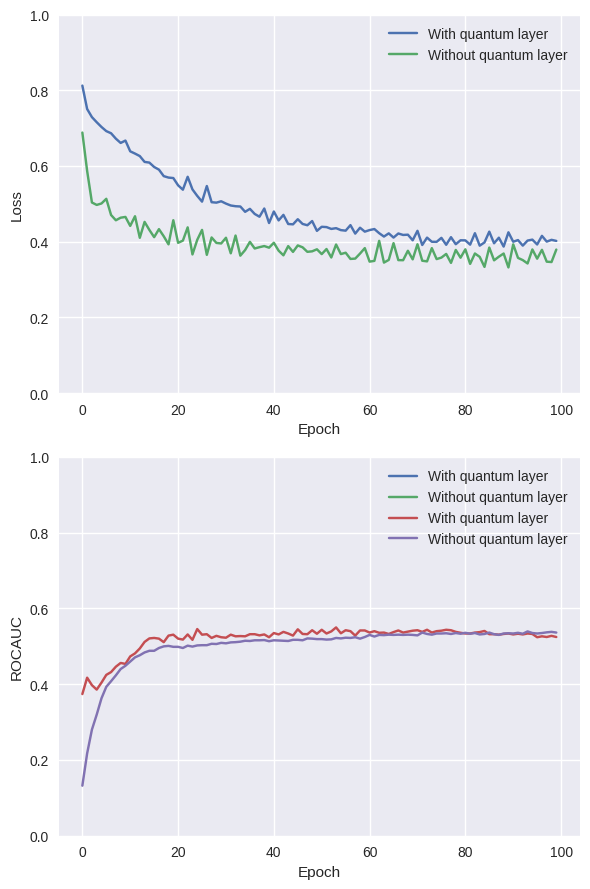

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 77.08%
Normal Model Accuracy: 79.17%
Hybrid Model F1 Score: 0.7405
Normal Model F1 Score: 0.7659
Hybrid Model AUC: 0.8338
Normal Model AUC: 0.8497


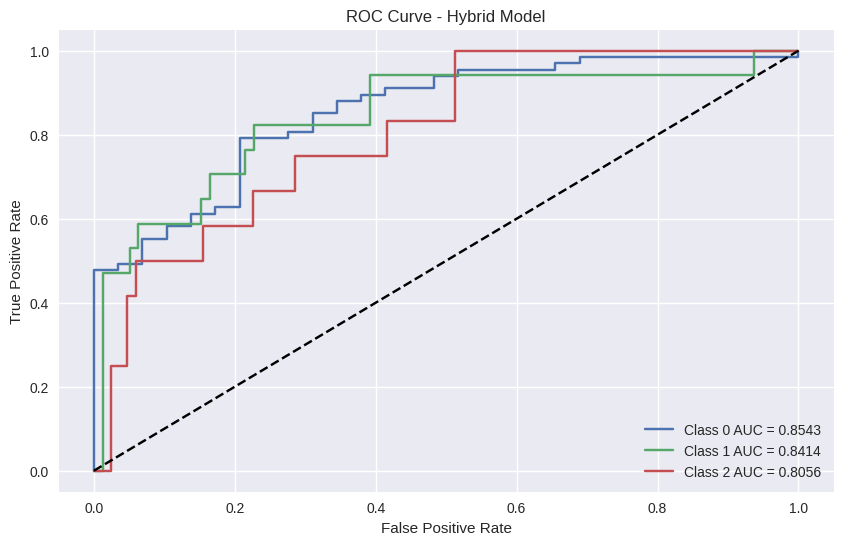

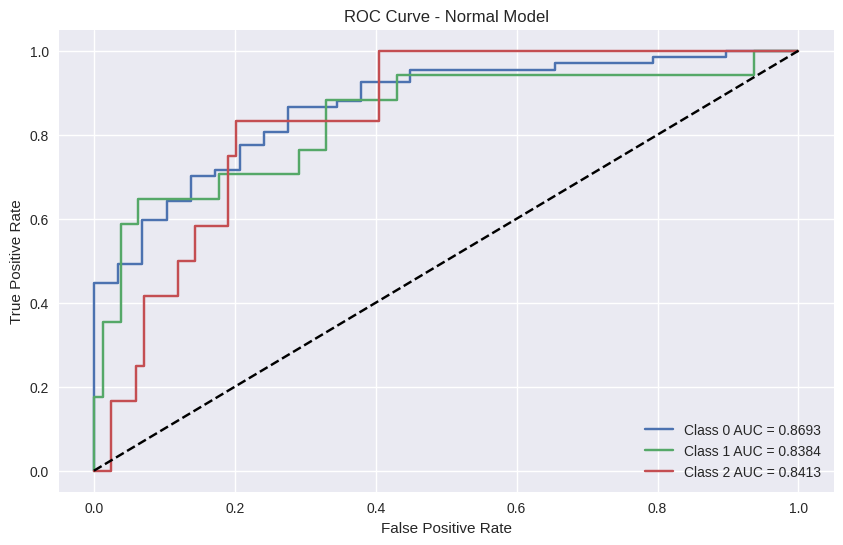

Hybrid Model AUPR: 0.6164
Normal Model AUPR: 0.6385


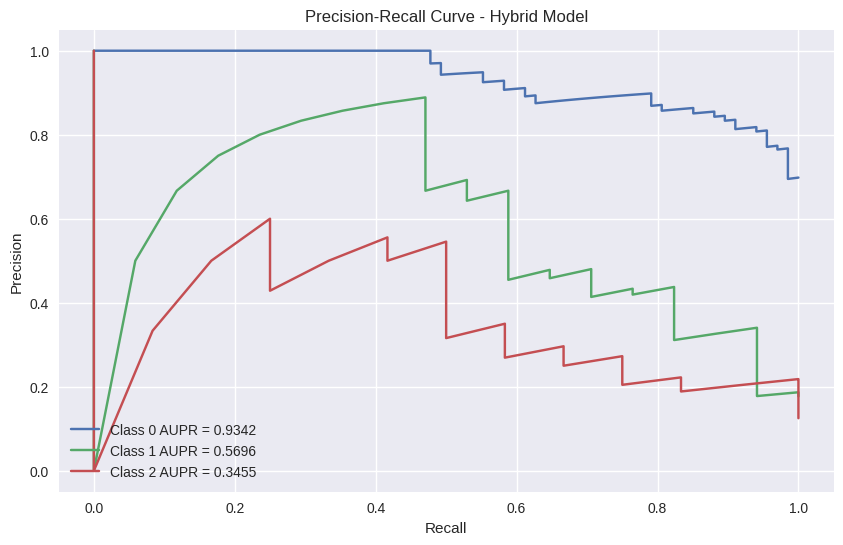

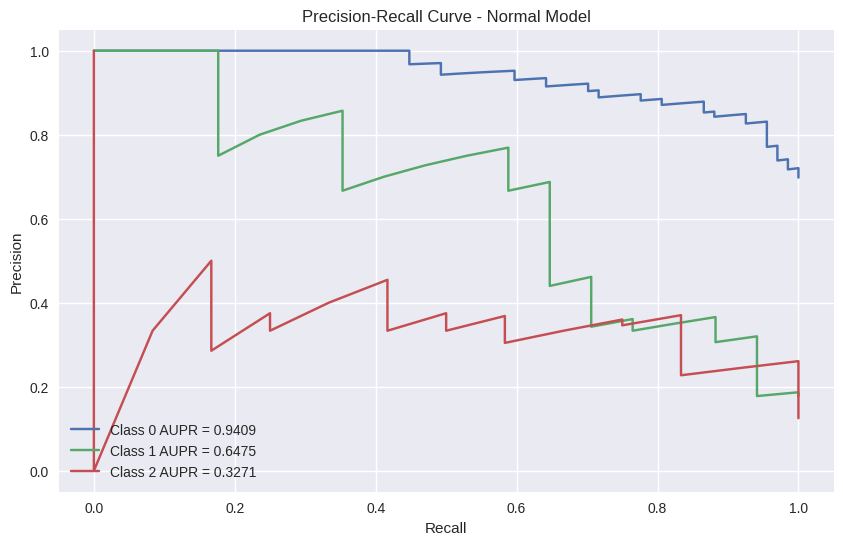

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.0667, Training Accuracy: 33.33%, Training AUROC: 0.5526
Validation Loss: 1.0841, Validation Accuracy: 7.81%, Validation AUROC: 0.4154
Epoch [2/100]
Training Loss: 0.9200, Training Accuracy: 51.04%, Training AUROC: 0.5384
Validation Loss: 0.6764, Validation Accuracy: 78.12%, Validation AUROC: 0.3704
Epoch [3/100]
Training Loss: 0.8041, Training Accuracy: 67.01%, Training AUROC: 0.5473
Validation Loss: 0.5009, Validation Accuracy: 84.38%, Validation AUROC: 0.3642
Epoch [4/100]
Training Loss: 0.7767, Training Accuracy: 68.06%, Training AUROC: 0.5966
Validation Loss: 0.4353, Validation Accuracy: 84.38%, Validation AUROC: 0.3988
Epoch [5/100]
Training Loss: 0.7763, Training Accuracy: 67.36%, Training AUROC: 0.6412
Validation Loss: 0.4225, Validation Accuracy: 84.38%, Validation AUROC: 0.4543
Epoch [6/100]
Training Loss: 0.7486, Training Accuracy: 70.14%, Training AUROC: 0.6125
Validation Loss: 0.4548, Validation Accuracy: 84.38%, Validation AUROC: 0.4704
Epoch

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.8399, Training Accuracy: 68.06%, Training AUROC: 0.5005
Validation Loss: 0.7202, Validation Accuracy: 84.38%, Validation AUROC: 0.2204
Epoch [2/100]
Training Loss: 0.8087, Training Accuracy: 68.75%, Training AUROC: 0.5308
Validation Loss: 0.5921, Validation Accuracy: 84.38%, Validation AUROC: 0.2815
Epoch [3/100]
Training Loss: 0.8003, Training Accuracy: 67.71%, Training AUROC: 0.5394
Validation Loss: 0.5484, Validation Accuracy: 84.38%, Validation AUROC: 0.2988
Epoch [4/100]
Training Loss: 0.7962, Training Accuracy: 67.01%, Training AUROC: 0.5745
Validation Loss: 0.5330, Validation Accuracy: 84.38%, Validation AUROC: 0.3228
Epoch [5/100]
Training Loss: 0.7874, Training Accuracy: 67.36%, Training AUROC: 0.5786
Validation Loss: 0.5241, Validation Accuracy: 84.38%, Validation AUROC: 0.3599
Epoch [6/100]
Training Loss: 0.7801, Training Accuracy: 68.06%, Training AUROC: 0.5717
Validation Loss: 0.5276, Validation Accuracy: 84.38%, Validation AUROC: 0.3660
Epoc

<ipython-input-19-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


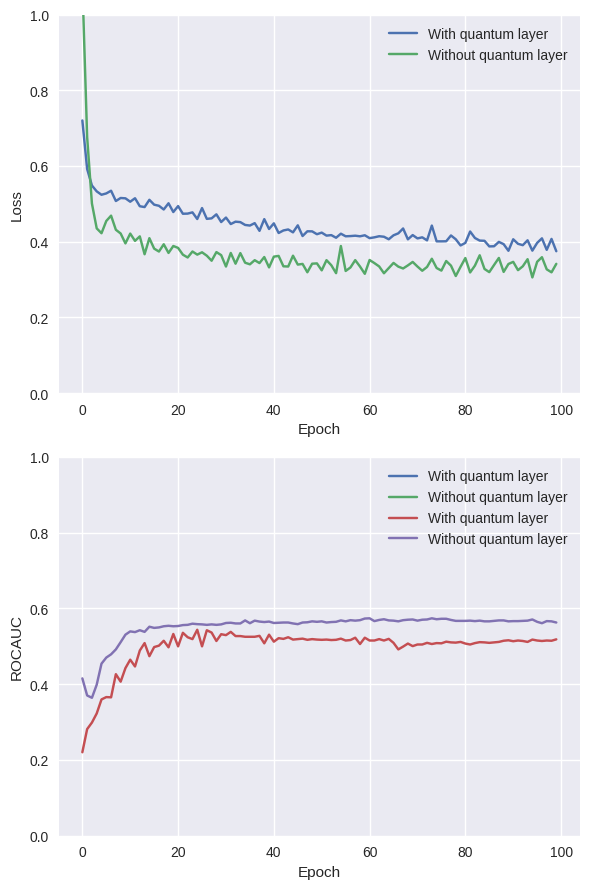

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 76.04%
Normal Model Accuracy: 77.08%
Hybrid Model F1 Score: 0.7159
Normal Model F1 Score: 0.7398
Hybrid Model AUC: 0.8189
Normal Model AUC: 0.8513


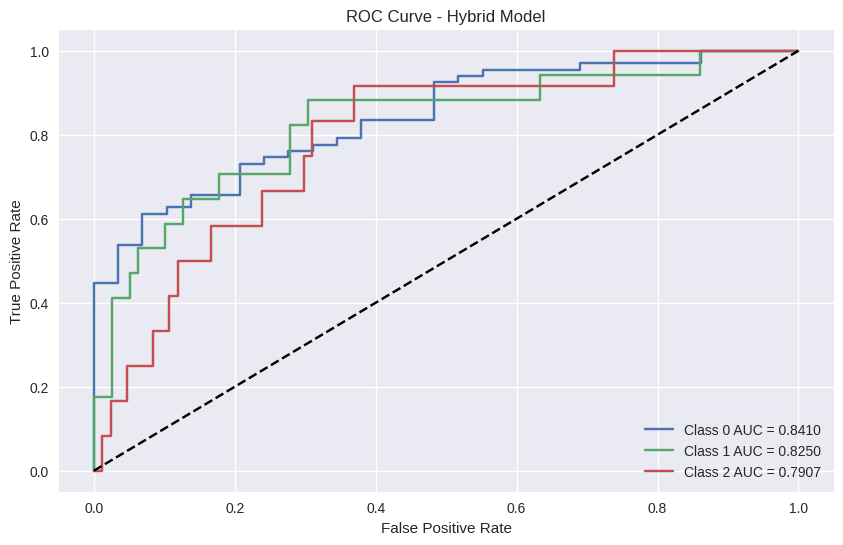

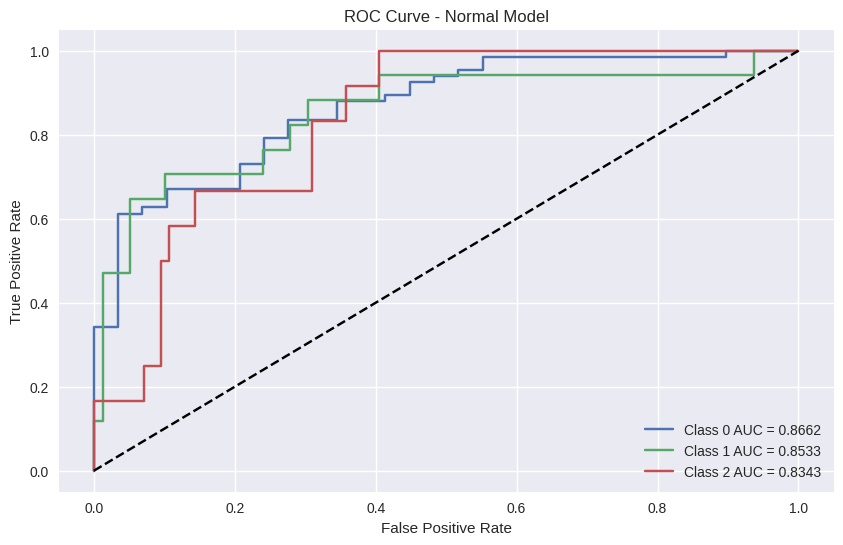

Hybrid Model AUPR: 0.6090
Normal Model AUPR: 0.6775


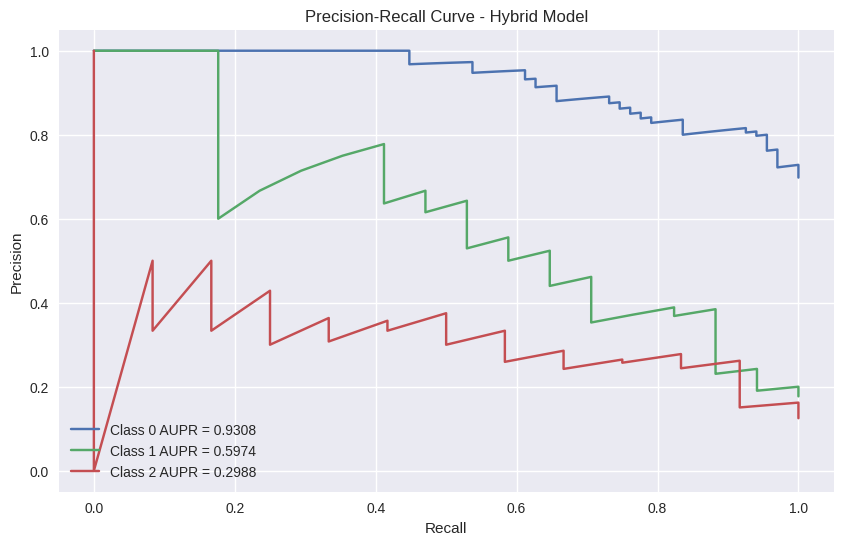

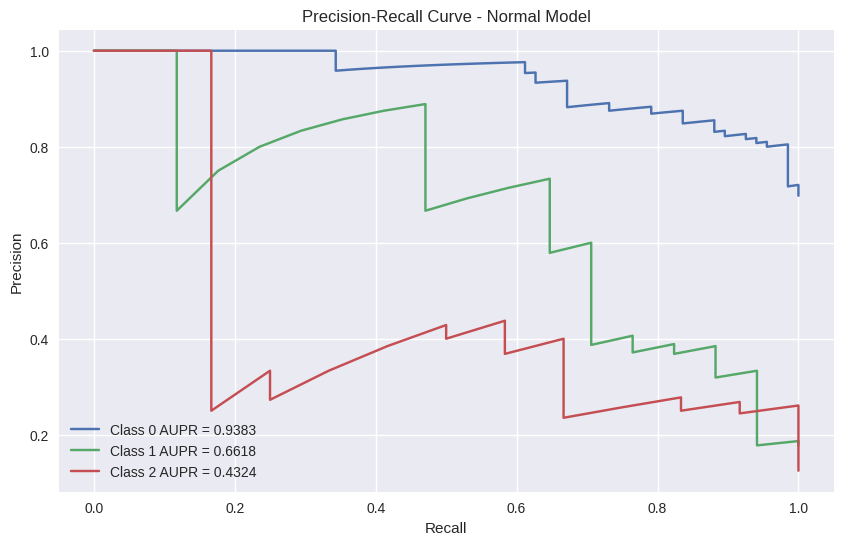

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.3412, Training Accuracy: 15.97%, Training AUROC: 0.5644
Validation Loss: 1.4034, Validation Accuracy: 3.12%, Validation AUROC: 0.4056
Epoch [2/100]
Training Loss: 1.1146, Training Accuracy: 28.82%, Training AUROC: 0.5497
Validation Loss: 0.9706, Validation Accuracy: 18.75%, Validation AUROC: 0.3846
Epoch [3/100]
Training Loss: 0.8689, Training Accuracy: 61.46%, Training AUROC: 0.5723
Validation Loss: 0.6375, Validation Accuracy: 81.25%, Validation AUROC: 0.2926
Epoch [4/100]
Training Loss: 0.7735, Training Accuracy: 67.36%, Training AUROC: 0.6127
Validation Loss: 0.4968, Validation Accuracy: 84.38%, Validation AUROC: 0.3142
Epoch [5/100]
Training Loss: 0.7754, Training Accuracy: 68.06%, Training AUROC: 0.6063
Validation Loss: 0.4484, Validation Accuracy: 84.38%, Validation AUROC: 0.3580
Epoch [6/100]
Training Loss: 0.7596, Training Accuracy: 68.40%, Training AUROC: 0.6231
Validation Loss: 0.4416, Validation Accuracy: 84.38%, Validation AUROC: 0.3778
Epoch

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 1.1376, Training Accuracy: 26.04%, Training AUROC: 0.5033
Validation Loss: 1.2045, Validation Accuracy: 14.06%, Validation AUROC: 0.2821
Epoch [2/100]
Training Loss: 0.9799, Training Accuracy: 44.10%, Training AUROC: 0.4877
Validation Loss: 0.7675, Validation Accuracy: 43.75%, Validation AUROC: 0.3580
Epoch [3/100]
Training Loss: 0.8197, Training Accuracy: 65.97%, Training AUROC: 0.5451
Validation Loss: 0.5742, Validation Accuracy: 82.81%, Validation AUROC: 0.3679
Epoch [4/100]
Training Loss: 0.8043, Training Accuracy: 67.71%, Training AUROC: 0.5041
Validation Loss: 0.5127, Validation Accuracy: 84.38%, Validation AUROC: 0.4062
Epoch [5/100]
Training Loss: 0.7937, Training Accuracy: 68.40%, Training AUROC: 0.5276
Validation Loss: 0.4967, Validation Accuracy: 84.38%, Validation AUROC: 0.4179
Epoch [6/100]
Training Loss: 0.7799, Training Accuracy: 68.75%, Training AUROC: 0.5692
Validation Loss: 0.4921, Validation Accuracy: 84.38%, Validation AUROC: 0.4235
Epoc

<ipython-input-19-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


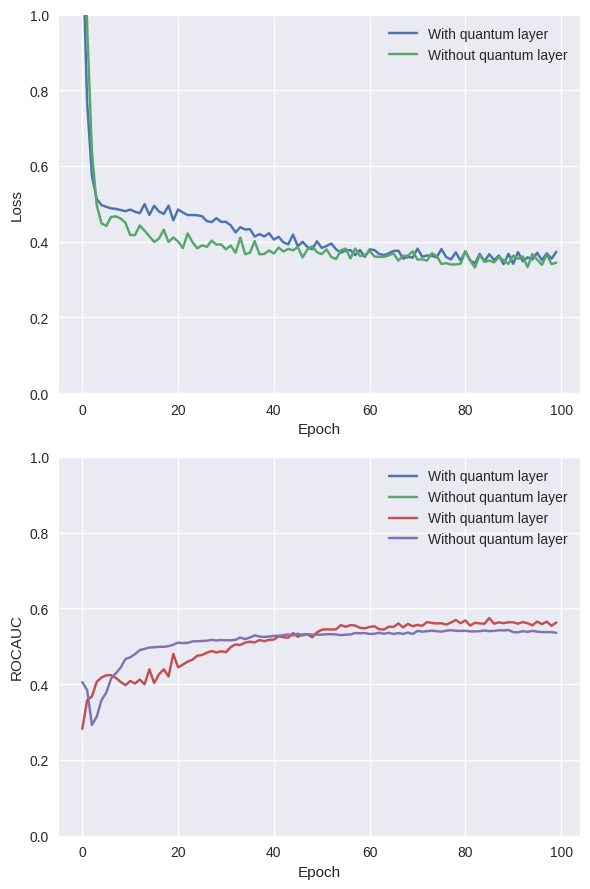

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 73.96%
Normal Model Accuracy: 76.04%
Hybrid Model F1 Score: 0.7219
Normal Model F1 Score: 0.7073
Hybrid Model AUC: 0.8308
Normal Model AUC: 0.8471


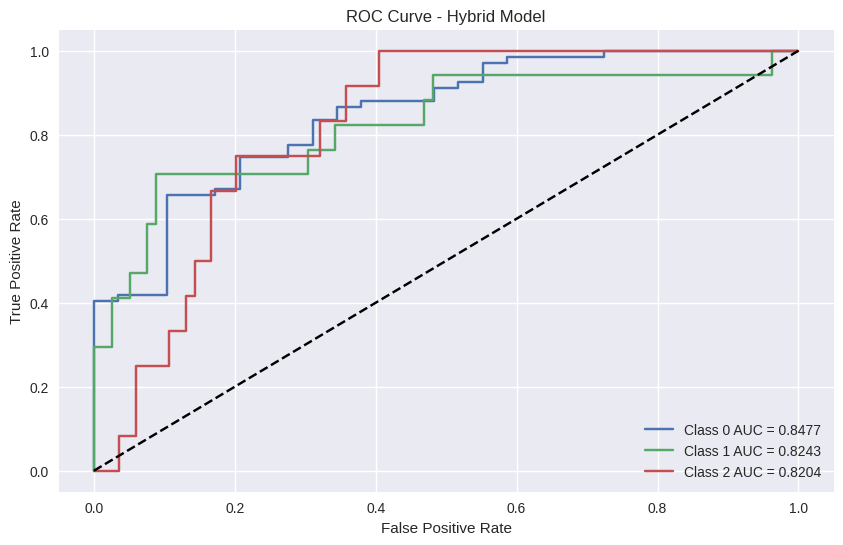

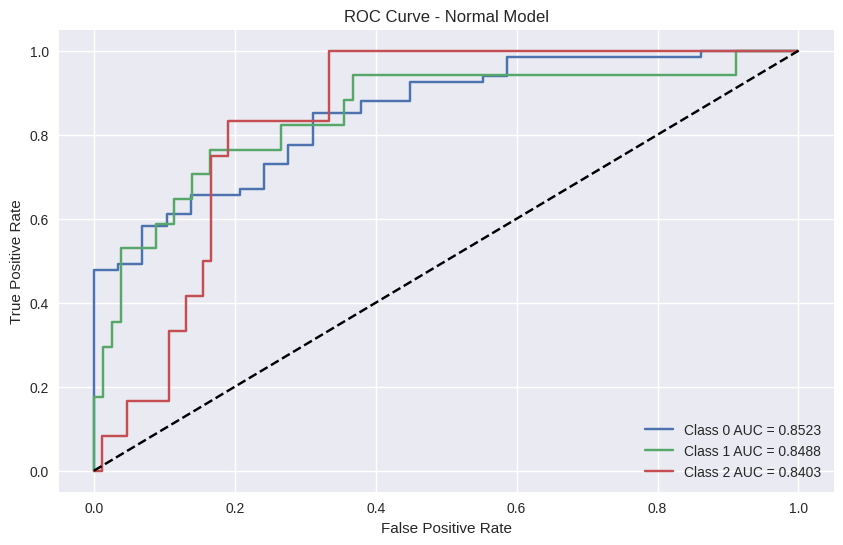

Hybrid Model AUPR: 0.6172
Normal Model AUPR: 0.6231


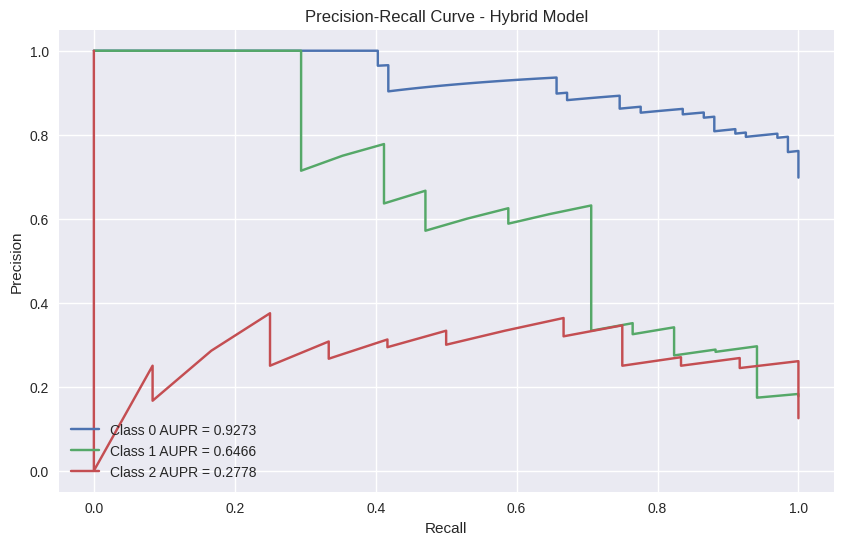

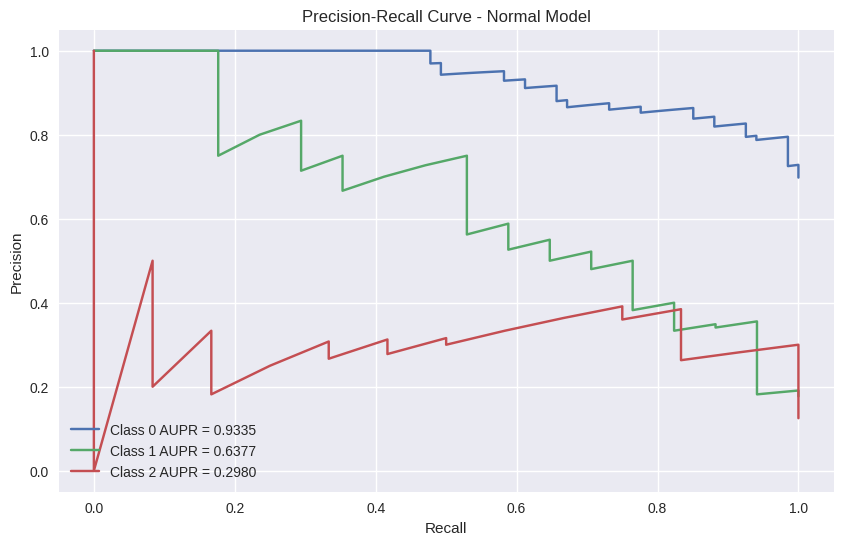

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experiments: Training Model 2-class PAPILA - Testing on 2-class PAPILA

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/"

In [ ]:
n_epochs = 100
num_classes = 2
q_depth = 4
batch_size = 32
dataset = "PAPILA"
model_name_hybrid = 'quantum_hybrid_model'
model_name_normal = 'normal_model'
PAPILA_dual_class=True

## Seed Experiment 1

In [ ]:
seed = 0
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6022, Training Accuracy: 64.58%, Training AUROC: 0.5062
Validation Loss: 0.5390, Validation Accuracy: 60.94%, Validation AUROC: 0.4407
Epoch [2/100]
Training Loss: 0.5767, Training Accuracy: 68.06%, Training AUROC: 0.5454
Validation Loss: 0.4016, Validation Accuracy: 85.94%, Validation AUROC: 0.5333
Epoch [3/100]
Training Loss: 0.5944, Training Accuracy: 65.97%, Training AUROC: 0.5492
Validation Loss: 0.3997, Validation Accuracy: 85.94%, Validation AUROC: 0.5759
Epoch [4/100]
Training Loss: 0.5592, Training Accuracy: 67.36%, Training AUROC: 0.6507
Validation Loss: 0.4047, Validation Accuracy: 85.94%, Validation AUROC: 0.6204
Epoch [5/100]
Training Loss: 0.5745, Training Accuracy: 67.36%, Training AUROC: 0.6107
Validation Loss: 0.3954, Validation Accuracy: 82.81%, Validation AUROC: 0.6852
Epoch [6/100]
Training Loss: 0.5402, Training Accuracy: 68.40%, Training AUROC: 0.6862
Validation Loss: 0.3606, Validation Accuracy: 84.38%, Validation AUROC: 0.7148
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6764, Training Accuracy: 48.61%, Training AUROC: 0.4028
Validation Loss: 0.4360, Validation Accuracy: 85.94%, Validation AUROC: 0.8111
Epoch [2/100]
Training Loss: 0.6157, Training Accuracy: 62.15%, Training AUROC: 0.4697
Validation Loss: 0.3535, Validation Accuracy: 82.81%, Validation AUROC: 0.7093
Epoch [3/100]
Training Loss: 0.6108, Training Accuracy: 68.40%, Training AUROC: 0.4664
Validation Loss: 0.3302, Validation Accuracy: 84.38%, Validation AUROC: 0.7352
Epoch [4/100]
Training Loss: 0.6073, Training Accuracy: 67.71%, Training AUROC: 0.4930
Validation Loss: 0.3606, Validation Accuracy: 84.38%, Validation AUROC: 0.7074
Epoch [5/100]
Training Loss: 0.5880, Training Accuracy: 66.67%, Training AUROC: 0.5409
Validation Loss: 0.3939, Validation Accuracy: 85.94%, Validation AUROC: 0.6648
Epoch [6/100]
Training Loss: 0.5704, Training Accuracy: 68.75%, Training AUROC: 0.5684
Validation Loss: 0.3812, Validation Accuracy: 84.38%, Validation AUROC: 0.6574
Epoc

In [ ]:
model_normal, model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_0.pth"), torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_0.pth")

<ipython-input-39-3240e2e3704d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_normal, model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments

<ipython-input-20-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


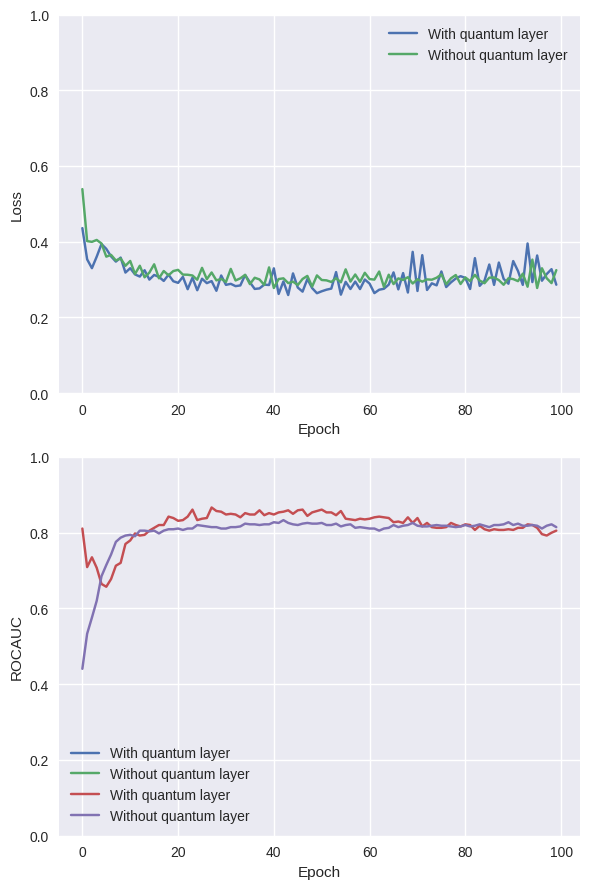

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 80.21%
Normal Model Accuracy: 83.33%
Hybrid Model F1 Score: 0.7934
Normal Model F1 Score: 0.8273
Hybrid Model AUC: 0.8446
Normal Model AUC: 0.8693


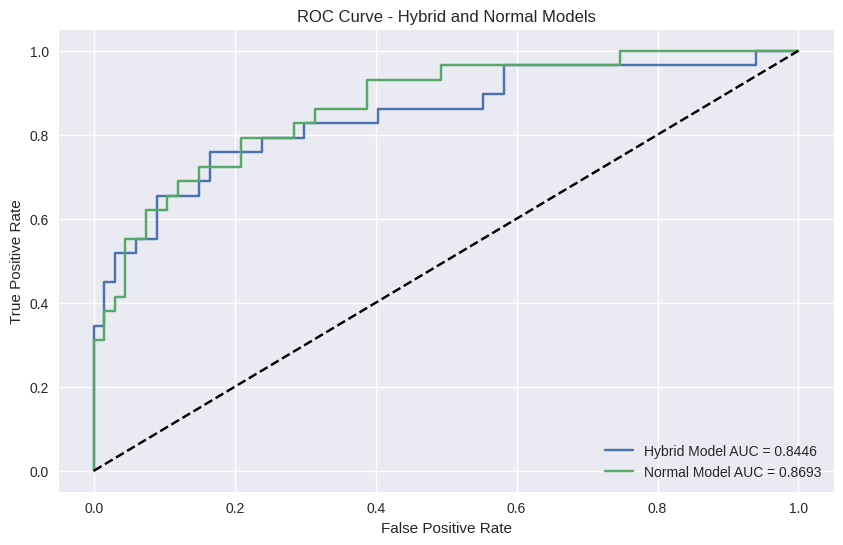

Hybrid Model AUPR: 0.7809
Normal Model AUPR: 0.7842


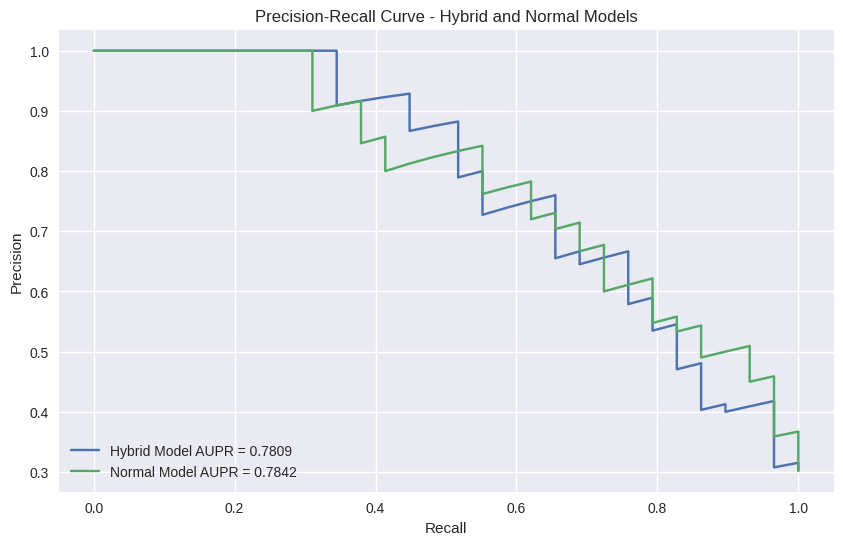

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 2

In [ ]:
seed = 42
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7150, Training Accuracy: 40.97%, Training AUROC: 0.4870
Validation Loss: 0.6332, Validation Accuracy: 32.81%, Validation AUROC: 0.6370
Epoch [2/100]
Training Loss: 0.6214, Training Accuracy: 59.38%, Training AUROC: 0.5157
Validation Loss: 0.4696, Validation Accuracy: 81.25%, Validation AUROC: 0.6148
Epoch [3/100]
Training Loss: 0.5797, Training Accuracy: 68.40%, Training AUROC: 0.5675
Validation Loss: 0.3904, Validation Accuracy: 84.38%, Validation AUROC: 0.5537
Epoch [4/100]
Training Loss: 0.5933, Training Accuracy: 67.71%, Training AUROC: 0.5485
Validation Loss: 0.3860, Validation Accuracy: 82.81%, Validation AUROC: 0.5944
Epoch [5/100]
Training Loss: 0.5779, Training Accuracy: 69.10%, Training AUROC: 0.5470
Validation Loss: 0.4262, Validation Accuracy: 79.69%, Validation AUROC: 0.6333
Epoch [6/100]
Training Loss: 0.5681, Training Accuracy: 68.40%, Training AUROC: 0.5996
Validation Loss: 0.4226, Validation Accuracy: 82.81%, Validation AUROC: 0.6444
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7072, Training Accuracy: 33.33%, Training AUROC: 0.4468
Validation Loss: 0.5948, Validation Accuracy: 39.06%, Validation AUROC: 0.4093
Epoch [2/100]
Training Loss: 0.6564, Training Accuracy: 45.83%, Training AUROC: 0.4818
Validation Loss: 0.5169, Validation Accuracy: 70.31%, Validation AUROC: 0.5037
Epoch [3/100]
Training Loss: 0.6101, Training Accuracy: 63.89%, Training AUROC: 0.4848
Validation Loss: 0.4535, Validation Accuracy: 85.94%, Validation AUROC: 0.5204
Epoch [4/100]
Training Loss: 0.5944, Training Accuracy: 66.67%, Training AUROC: 0.4899
Validation Loss: 0.4264, Validation Accuracy: 84.38%, Validation AUROC: 0.4685
Epoch [5/100]
Training Loss: 0.5788, Training Accuracy: 68.40%, Training AUROC: 0.5414
Validation Loss: 0.4193, Validation Accuracy: 84.38%, Validation AUROC: 0.4981
Epoch [6/100]
Training Loss: 0.5795, Training Accuracy: 68.06%, Training AUROC: 0.5882
Validation Loss: 0.4171, Validation Accuracy: 84.38%, Validation AUROC: 0.5204
Epoc

<ipython-input-20-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


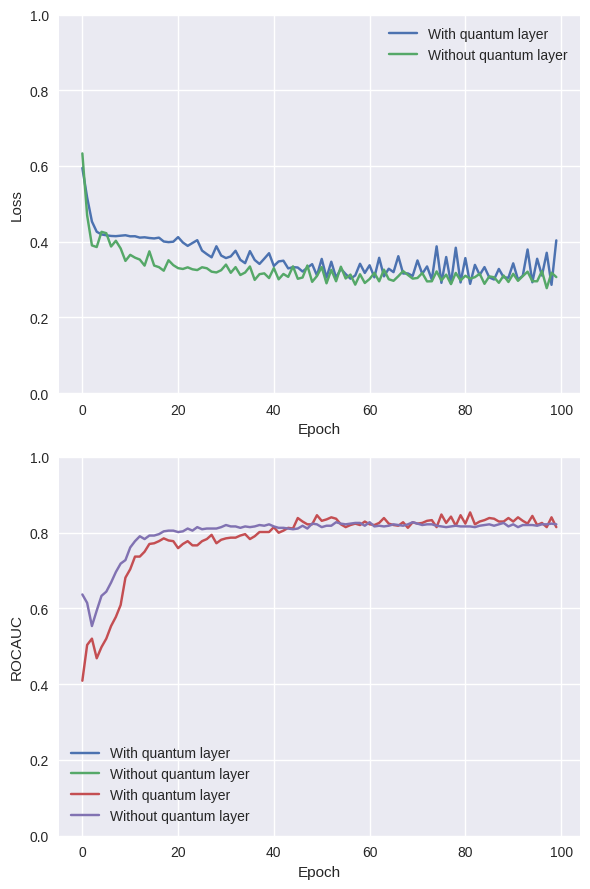

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 71.88%
Normal Model Accuracy: 82.29%
Hybrid Model F1 Score: 0.7224
Normal Model F1 Score: 0.8122
Hybrid Model AUC: 0.8477
Normal Model AUC: 0.8698


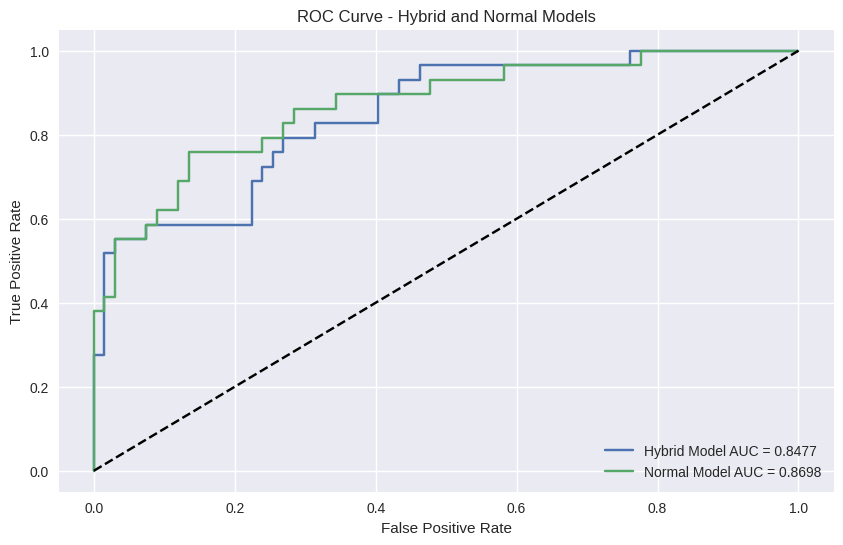

Hybrid Model AUPR: 0.7656
Normal Model AUPR: 0.7998


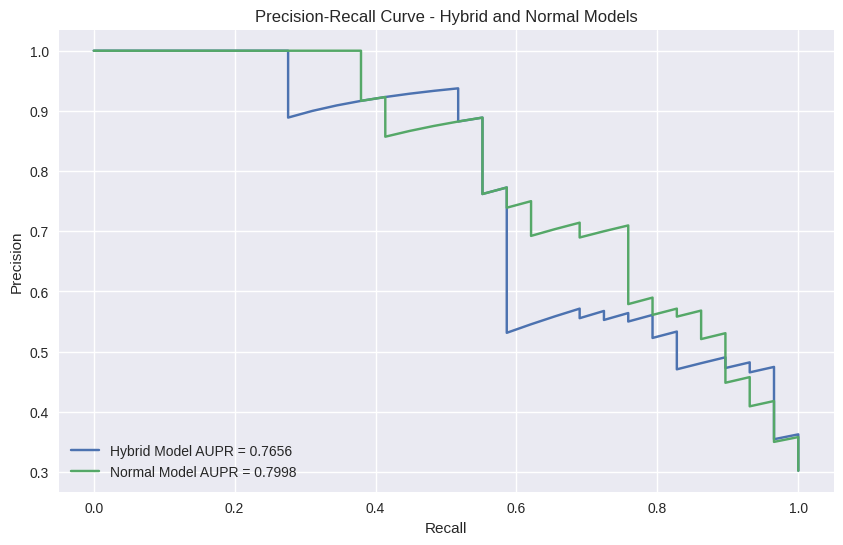

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 3

In [ ]:
seed = 5923
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6452, Training Accuracy: 54.51%, Training AUROC: 0.5607
Validation Loss: 0.5697, Validation Accuracy: 56.25%, Validation AUROC: 0.1833
Epoch [2/100]
Training Loss: 0.6024, Training Accuracy: 65.28%, Training AUROC: 0.5325
Validation Loss: 0.4664, Validation Accuracy: 76.56%, Validation AUROC: 0.3167
Epoch [3/100]
Training Loss: 0.5896, Training Accuracy: 66.32%, Training AUROC: 0.5731
Validation Loss: 0.4292, Validation Accuracy: 78.12%, Validation AUROC: 0.4241
Epoch [4/100]
Training Loss: 0.6023, Training Accuracy: 64.58%, Training AUROC: 0.5595
Validation Loss: 0.4450, Validation Accuracy: 75.00%, Validation AUROC: 0.5185
Epoch [5/100]
Training Loss: 0.5698, Training Accuracy: 65.97%, Training AUROC: 0.6105
Validation Loss: 0.4532, Validation Accuracy: 75.00%, Validation AUROC: 0.5759
Epoch [6/100]
Training Loss: 0.5519, Training Accuracy: 68.40%, Training AUROC: 0.6497
Validation Loss: 0.4030, Validation Accuracy: 81.25%, Validation AUROC: 0.6019
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.5835, Training Accuracy: 68.75%, Training AUROC: 0.5590
Validation Loss: 0.4564, Validation Accuracy: 84.38%, Validation AUROC: 0.4519
Epoch [2/100]
Training Loss: 0.5804, Training Accuracy: 67.71%, Training AUROC: 0.5641
Validation Loss: 0.4254, Validation Accuracy: 84.38%, Validation AUROC: 0.5093
Epoch [3/100]
Training Loss: 0.5747, Training Accuracy: 68.06%, Training AUROC: 0.5891
Validation Loss: 0.4074, Validation Accuracy: 84.38%, Validation AUROC: 0.6481
Epoch [4/100]
Training Loss: 0.5694, Training Accuracy: 68.06%, Training AUROC: 0.6669
Validation Loss: 0.4020, Validation Accuracy: 84.38%, Validation AUROC: 0.7037
Epoch [5/100]
Training Loss: 0.5664, Training Accuracy: 68.40%, Training AUROC: 0.6727
Validation Loss: 0.3997, Validation Accuracy: 84.38%, Validation AUROC: 0.7259
Epoch [6/100]
Training Loss: 0.5664, Training Accuracy: 67.71%, Training AUROC: 0.6881
Validation Loss: 0.4094, Validation Accuracy: 84.38%, Validation AUROC: 0.7519
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


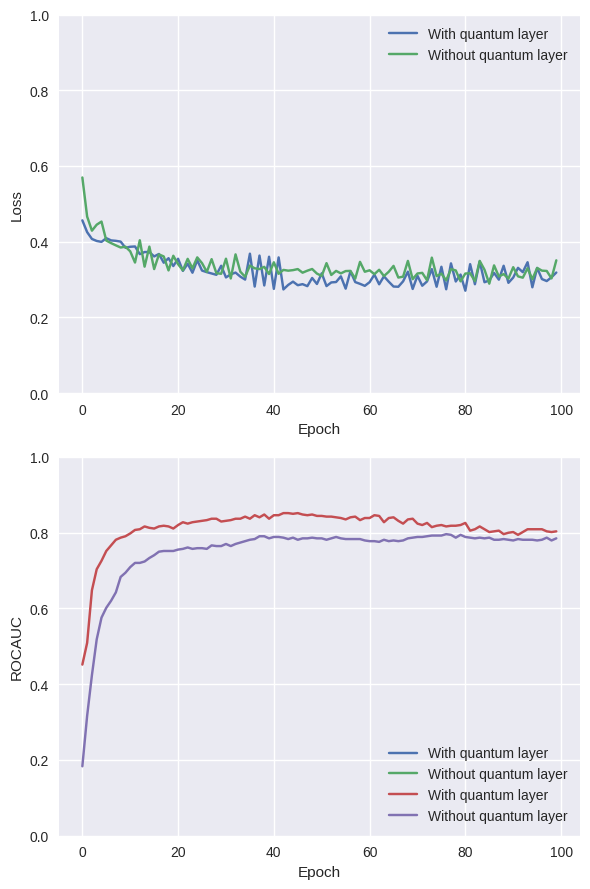

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 77.08%
Normal Model Accuracy: 83.33%
Hybrid Model F1 Score: 0.7625
Normal Model F1 Score: 0.8296
Hybrid Model AUC: 0.8713
Normal Model AUC: 0.8785


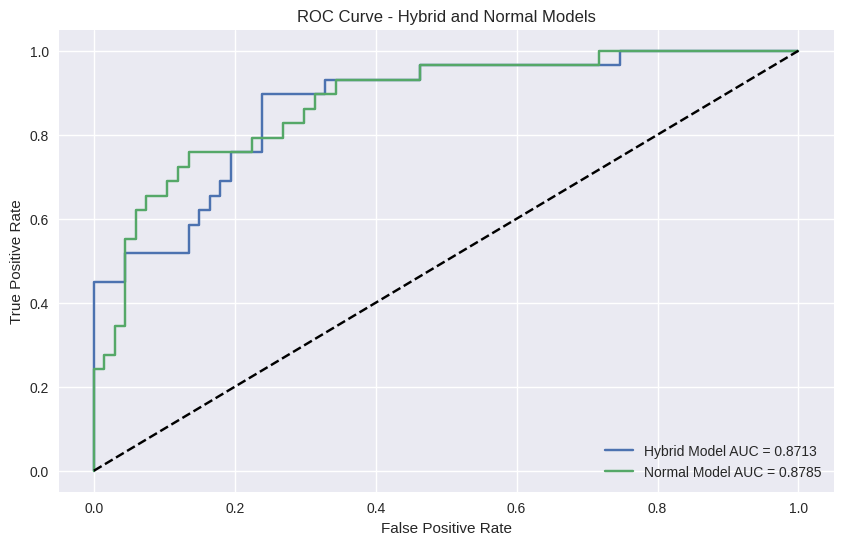

Hybrid Model AUPR: 0.7869
Normal Model AUPR: 0.7788


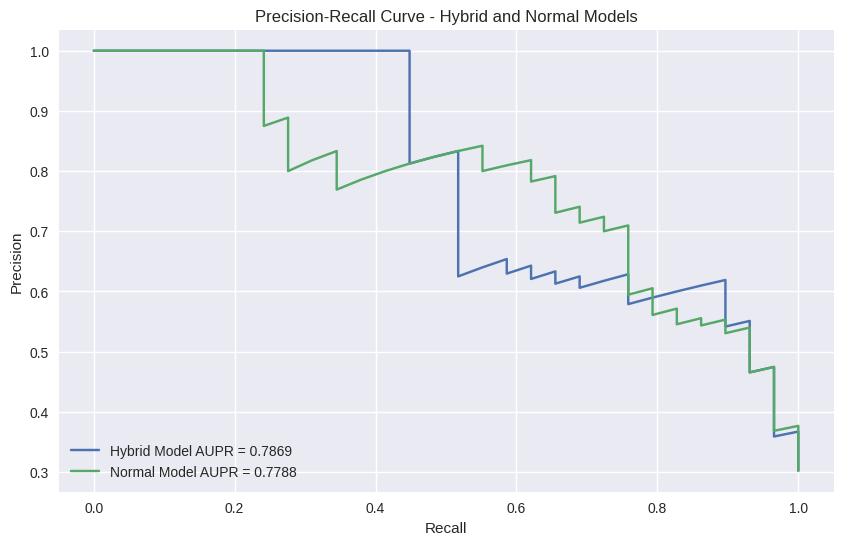

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 4

In [ ]:
seed = 8932
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6389, Training Accuracy: 53.12%, Training AUROC: 0.5630
Validation Loss: 0.5972, Validation Accuracy: 39.06%, Validation AUROC: 0.6500
Epoch [2/100]
Training Loss: 0.5938, Training Accuracy: 63.19%, Training AUROC: 0.5413
Validation Loss: 0.4393, Validation Accuracy: 81.25%, Validation AUROC: 0.5870
Epoch [3/100]
Training Loss: 0.5915, Training Accuracy: 68.40%, Training AUROC: 0.5381
Validation Loss: 0.3838, Validation Accuracy: 82.81%, Validation AUROC: 0.5648
Epoch [4/100]
Training Loss: 0.5696, Training Accuracy: 67.71%, Training AUROC: 0.6098
Validation Loss: 0.4003, Validation Accuracy: 85.94%, Validation AUROC: 0.6407
Epoch [5/100]
Training Loss: 0.5557, Training Accuracy: 67.01%, Training AUROC: 0.6442
Validation Loss: 0.4206, Validation Accuracy: 85.94%, Validation AUROC: 0.7019
Epoch [6/100]
Training Loss: 0.5436, Training Accuracy: 69.44%, Training AUROC: 0.6548
Validation Loss: 0.3605, Validation Accuracy: 84.38%, Validation AUROC: 0.7148
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6029, Training Accuracy: 67.01%, Training AUROC: 0.4899
Validation Loss: 0.3692, Validation Accuracy: 84.38%, Validation AUROC: 0.5519
Epoch [2/100]
Training Loss: 0.5915, Training Accuracy: 67.36%, Training AUROC: 0.5062
Validation Loss: 0.3767, Validation Accuracy: 82.81%, Validation AUROC: 0.6389
Epoch [3/100]
Training Loss: 0.5771, Training Accuracy: 68.06%, Training AUROC: 0.5375
Validation Loss: 0.3809, Validation Accuracy: 82.81%, Validation AUROC: 0.6481
Epoch [4/100]
Training Loss: 0.5836, Training Accuracy: 67.36%, Training AUROC: 0.5473
Validation Loss: 0.3989, Validation Accuracy: 82.81%, Validation AUROC: 0.6519
Epoch [5/100]
Training Loss: 0.5693, Training Accuracy: 67.36%, Training AUROC: 0.6114
Validation Loss: 0.3955, Validation Accuracy: 84.38%, Validation AUROC: 0.6519
Epoch [6/100]
Training Loss: 0.5614, Training Accuracy: 67.01%, Training AUROC: 0.6707
Validation Loss: 0.4148, Validation Accuracy: 84.38%, Validation AUROC: 0.6537
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


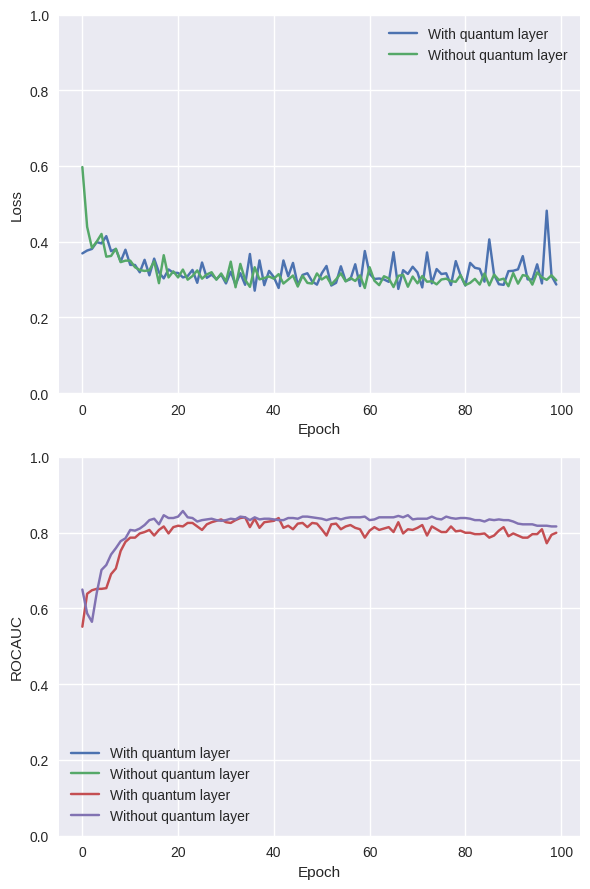

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 80.21%
Normal Model Accuracy: 81.25%
Hybrid Model F1 Score: 0.7822
Normal Model F1 Score: 0.7995
Hybrid Model AUC: 0.8621
Normal Model AUC: 0.8641


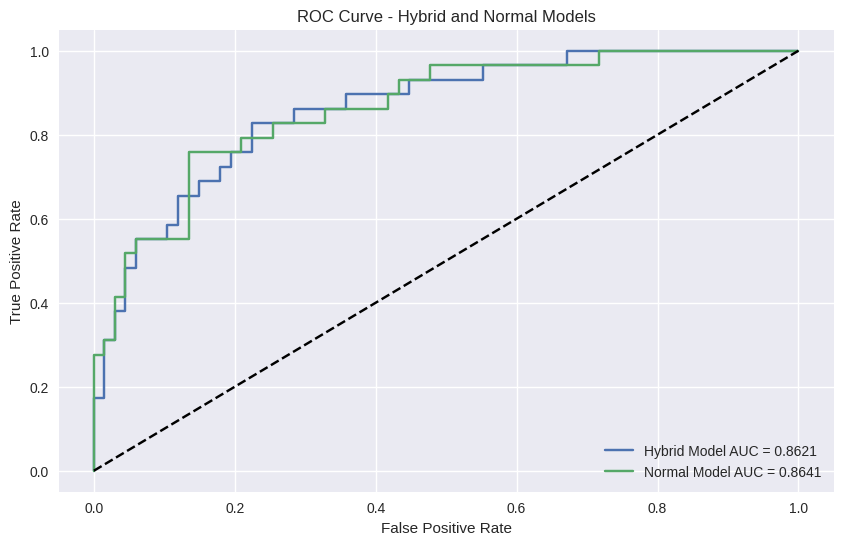

Hybrid Model AUPR: 0.7490
Normal Model AUPR: 0.7667


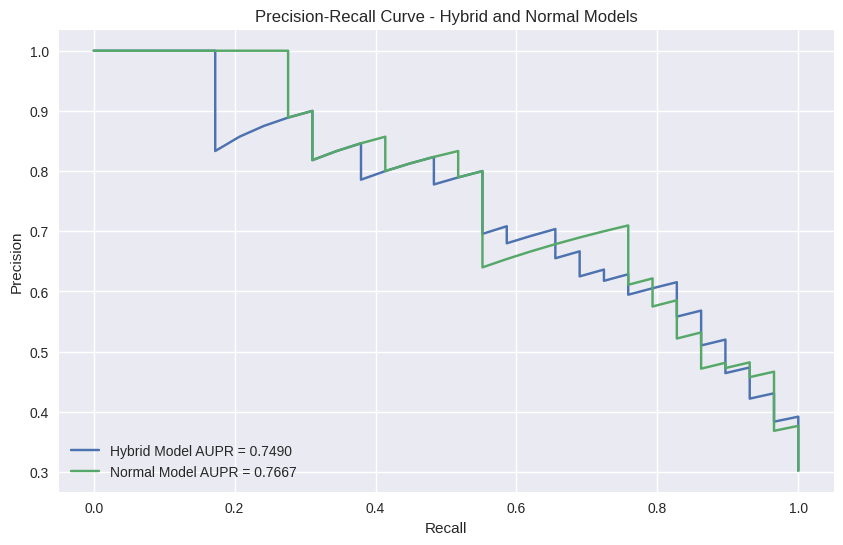

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

## Seed Experiments 5

In [ ]:
seed = 56
set_seed(seed)
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset, PAPILA_dual_class=PAPILA_dual_class)
model = NormalModel(freeze=True, num_classes=num_classes)
hybrid_model = QuantumHybridModel(q_depth=4, freeze=True, num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_normal, normal_train_losses, normal_train_accs, normal_val_losses, normal_val_accs, normal_train_aucs, normal_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=model,
    model_name=model_name_normal,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.7820, Training Accuracy: 38.89%, Training AUROC: 0.4918
Validation Loss: 0.7702, Validation Accuracy: 15.62%, Validation AUROC: 0.6907
Epoch [2/100]
Training Loss: 0.6471, Training Accuracy: 53.82%, Training AUROC: 0.5642
Validation Loss: 0.5574, Validation Accuracy: 56.25%, Validation AUROC: 0.5833
Epoch [3/100]
Training Loss: 0.5935, Training Accuracy: 65.62%, Training AUROC: 0.5454
Validation Loss: 0.4213, Validation Accuracy: 84.38%, Validation AUROC: 0.4500
Epoch [4/100]
Training Loss: 0.5867, Training Accuracy: 68.40%, Training AUROC: 0.5720
Validation Loss: 0.3816, Validation Accuracy: 84.38%, Validation AUROC: 0.4741
Epoch [5/100]
Training Loss: 0.5800, Training Accuracy: 67.71%, Training AUROC: 0.5795
Validation Loss: 0.4036, Validation Accuracy: 84.38%, Validation AUROC: 0.5370
Epoch [6/100]
Training Loss: 0.5803, Training Accuracy: 67.71%, Training AUROC: 0.5734
Validation Loss: 0.4216, Validation Accuracy: 81.25%, Validation AUROC: 0.5704
Epoc

In [ ]:
model_hybrid, hybrid_train_losses, hybrid_train_accs, hybrid_val_losses, hybrid_val_accs, hybrid_train_aucs, hybrid_val_aucs = train_validate_model(
    n_epochs=n_epochs,
    model=hybrid_model,
    model_name=model_name_hybrid,
    train_loader=train_loader,
    valid_loader=valid_loader,
    seed=seed
)

Epoch [1/100]
Training Loss: 0.6385, Training Accuracy: 54.86%, Training AUROC: 0.5750
Validation Loss: 0.5123, Validation Accuracy: 73.44%, Validation AUROC: 0.4870
Epoch [2/100]
Training Loss: 0.6025, Training Accuracy: 67.71%, Training AUROC: 0.5666
Validation Loss: 0.4646, Validation Accuracy: 84.38%, Validation AUROC: 0.4907
Epoch [3/100]
Training Loss: 0.5815, Training Accuracy: 68.40%, Training AUROC: 0.5883
Validation Loss: 0.4410, Validation Accuracy: 84.38%, Validation AUROC: 0.5111
Epoch [4/100]
Training Loss: 0.5789, Training Accuracy: 67.71%, Training AUROC: 0.6356
Validation Loss: 0.4279, Validation Accuracy: 84.38%, Validation AUROC: 0.5630
Epoch [5/100]
Training Loss: 0.5802, Training Accuracy: 67.71%, Training AUROC: 0.5830
Validation Loss: 0.4232, Validation Accuracy: 84.38%, Validation AUROC: 0.5963
Epoch [6/100]
Training Loss: 0.5730, Training Accuracy: 68.40%, Training AUROC: 0.6590
Validation Loss: 0.4217, Validation Accuracy: 84.38%, Validation AUROC: 0.6148
Epoc

<ipython-input-17-c59c089c574e>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


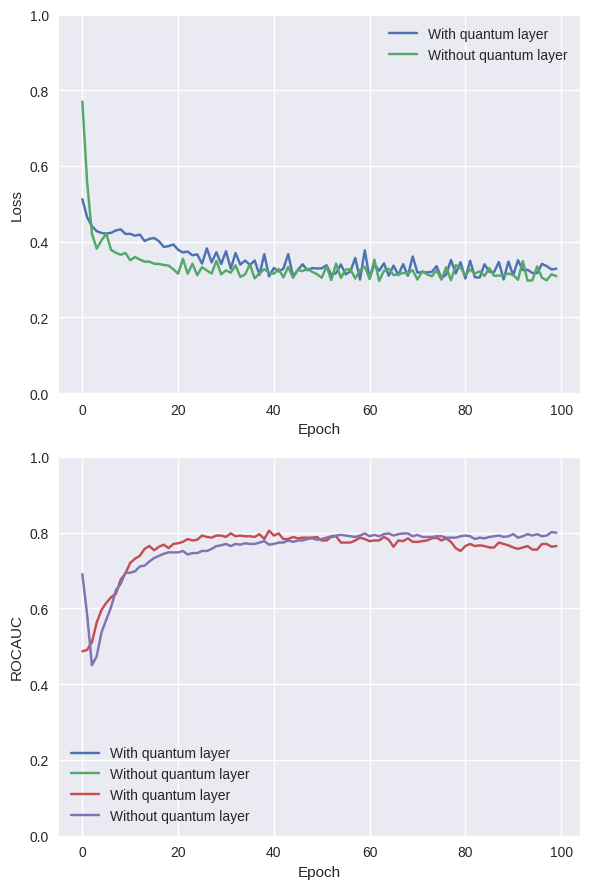

In [ ]:
plot(hybrid_val_losses, normal_val_losses, hybrid_val_accs, normal_val_accs, hybrid_val_aucs, normal_val_aucs)

Hybrid Model Accuracy: 81.25%
Normal Model Accuracy: 80.21%
Hybrid Model F1 Score: 0.8057
Normal Model F1 Score: 0.7901
Hybrid Model AUC: 0.8312
Normal Model AUC: 0.8585


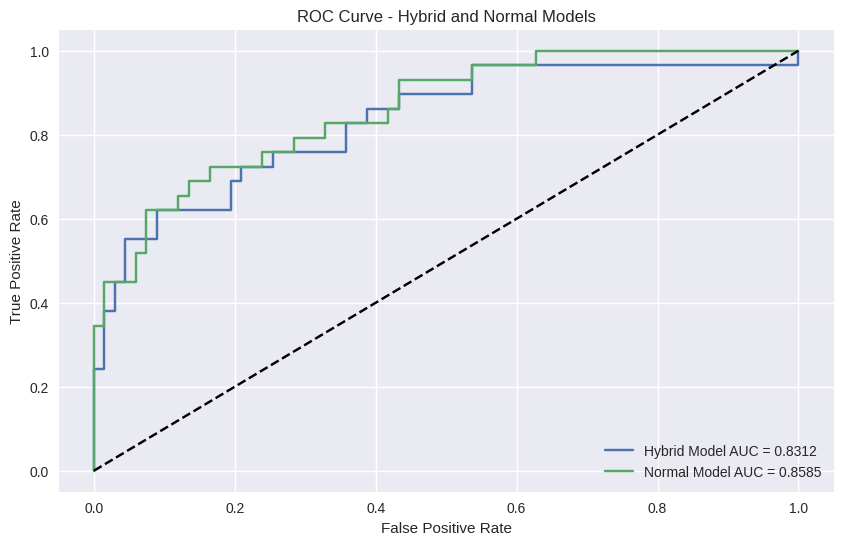

Hybrid Model AUPR: 0.7481
Normal Model AUPR: 0.7768


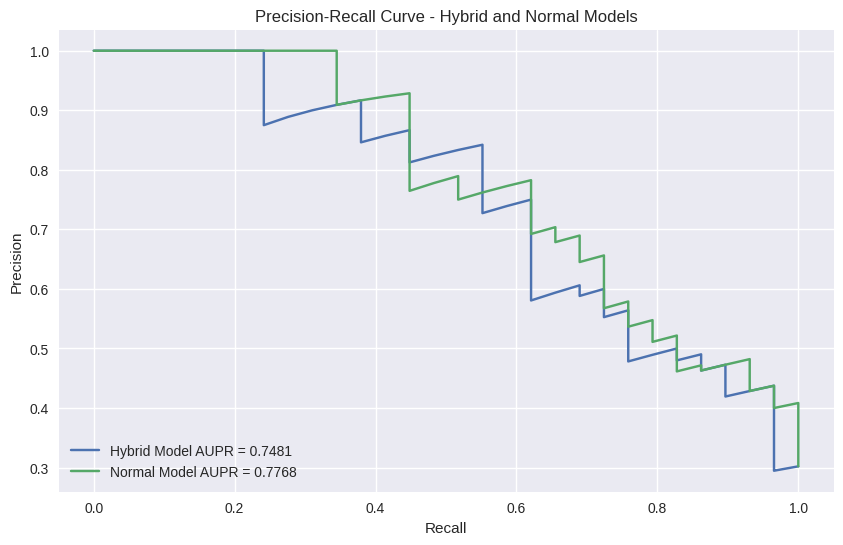

In [ ]:
test(model_hybrid, model_normal, test_loader, num_classes=num_classes)

# Experimenting PAPILA-dual-class Trained Model on G1020

In [ ]:
batch_size = 32
dataset = "G1020"
num_classes= 2
q_depth = 4

In [ ]:
train_loader, valid_loader, test_loader = load_data(batch_size=batch_size, dataset=dataset)

### Testing Model From Seed 1

Hybrid Model Accuracy: 68.06%
Normal Model Accuracy: 64.93%
Hybrid Model F1 Score: 0.6637
Normal Model F1 Score: 0.6586
Hybrid Model AUC: 0.5383
Normal Model AUC: 0.5586


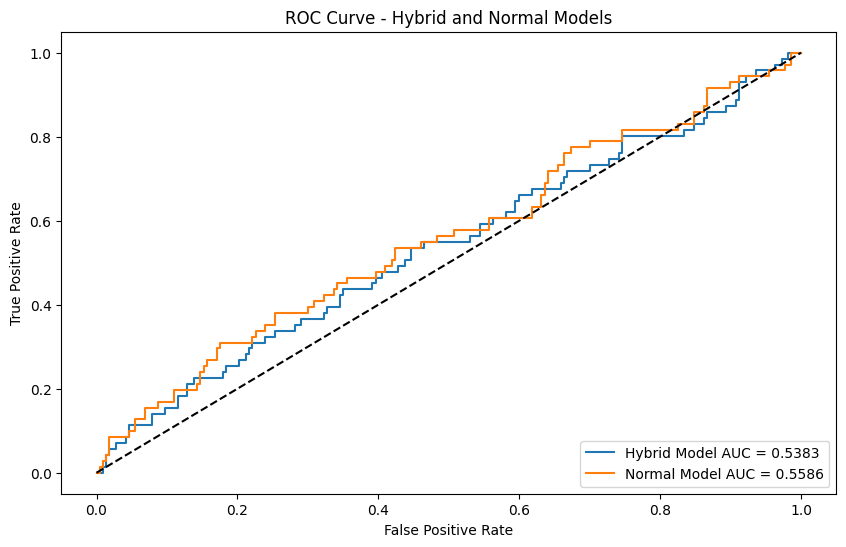

Hybrid Model AUPR: 0.2863
Normal Model AUPR: 0.3067


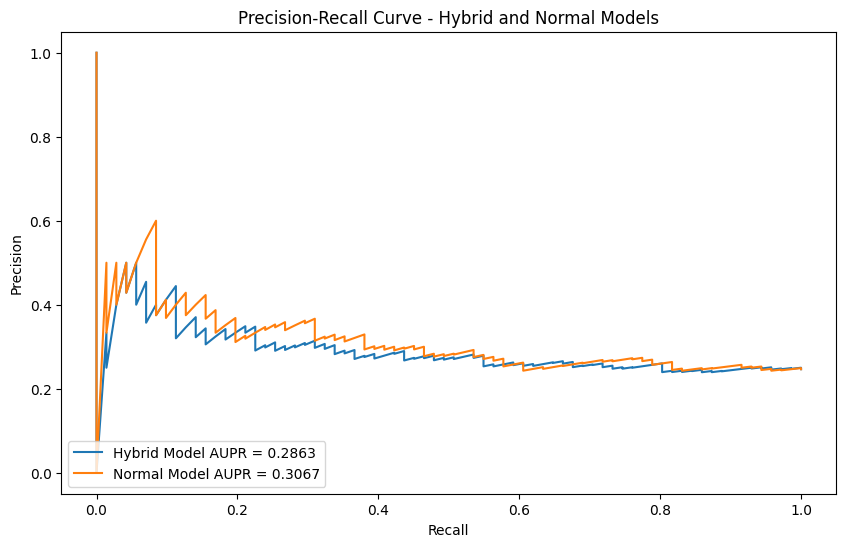

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_0.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_0.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 2

Hybrid Model Accuracy: 67.36%
Normal Model Accuracy: 69.79%
Hybrid Model F1 Score: 0.6668
Normal Model F1 Score: 0.6763
Hybrid Model AUC: 0.5743
Normal Model AUC: 0.5461


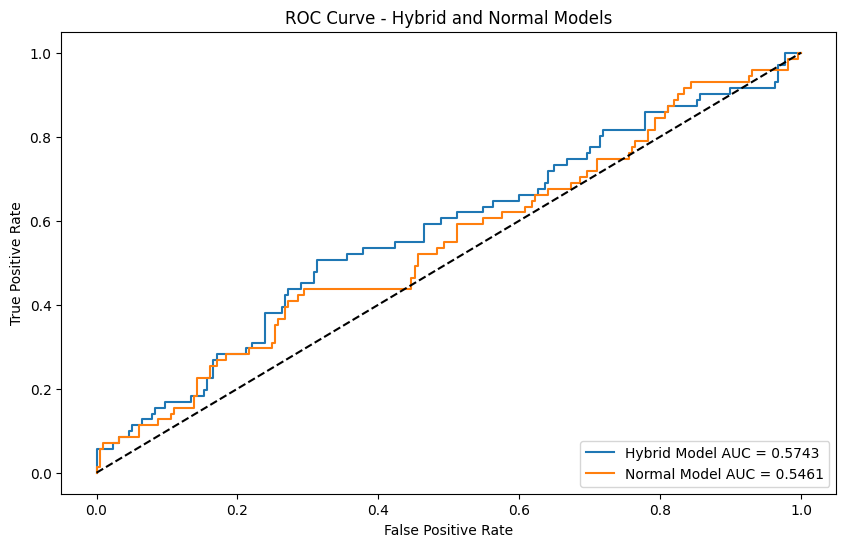

Hybrid Model AUPR: 0.3416
Normal Model AUPR: 0.3136


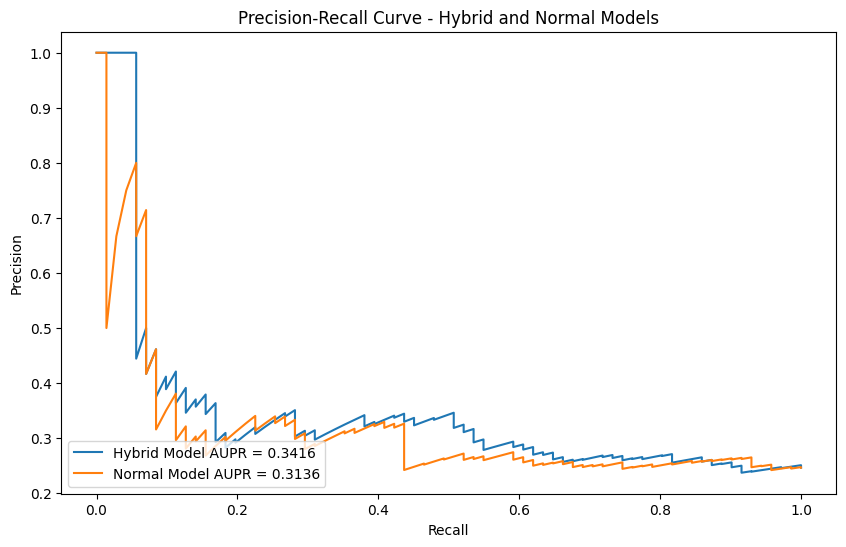

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_42.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_42.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 3

Hybrid Model Accuracy: 70.83%
Normal Model Accuracy: 67.36%
Hybrid Model F1 Score: 0.6700
Normal Model F1 Score: 0.6540
Hybrid Model AUC: 0.5622
Normal Model AUC: 0.5309


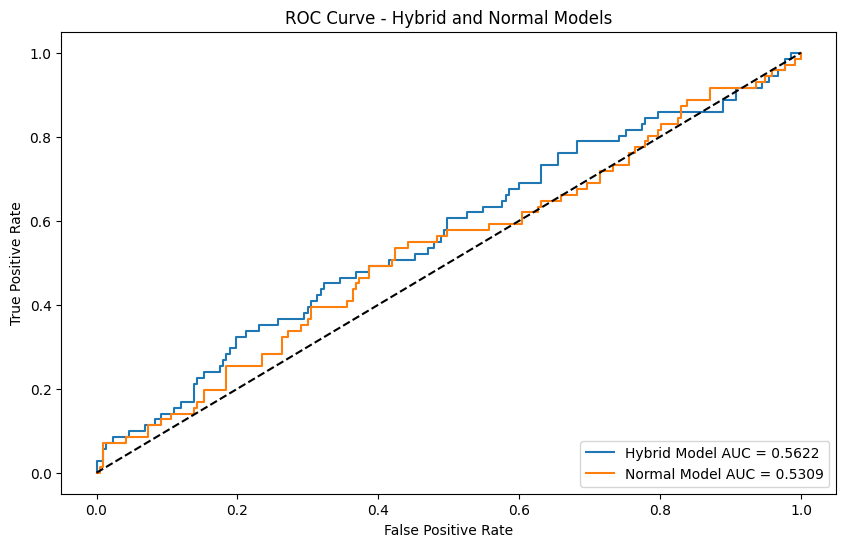

Hybrid Model AUPR: 0.3239
Normal Model AUPR: 0.2848


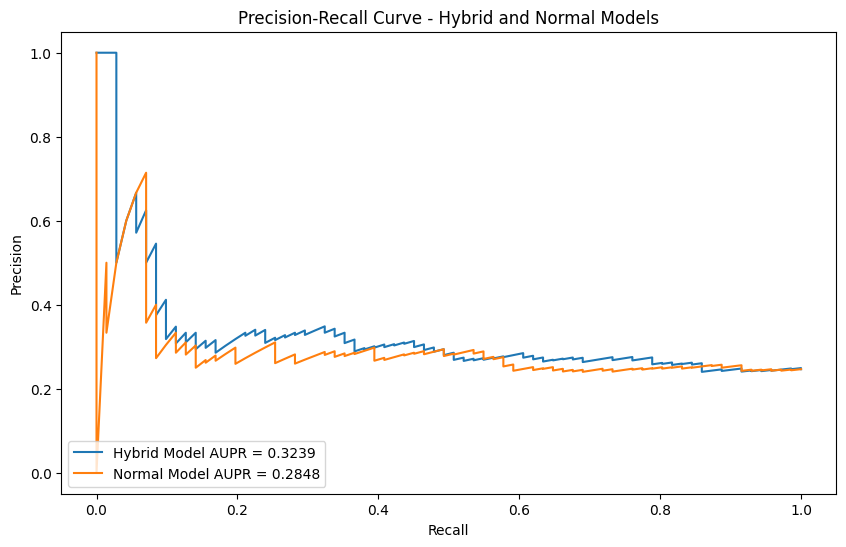

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_56.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_56.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 4

Hybrid Model Accuracy: 71.53%
Normal Model Accuracy: 68.06%
Hybrid Model F1 Score: 0.6778
Normal Model F1 Score: 0.6564
Hybrid Model AUC: 0.5255
Normal Model AUC: 0.5462


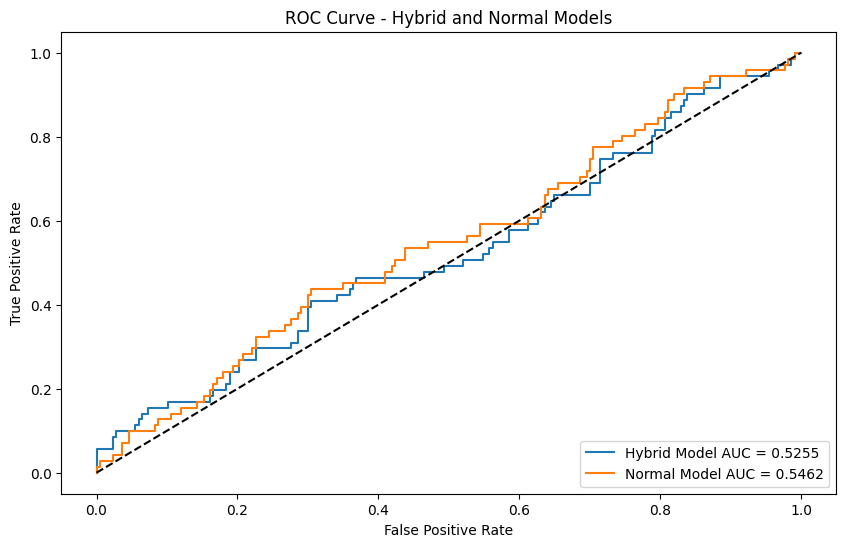

Hybrid Model AUPR: 0.3199
Normal Model AUPR: 0.2933


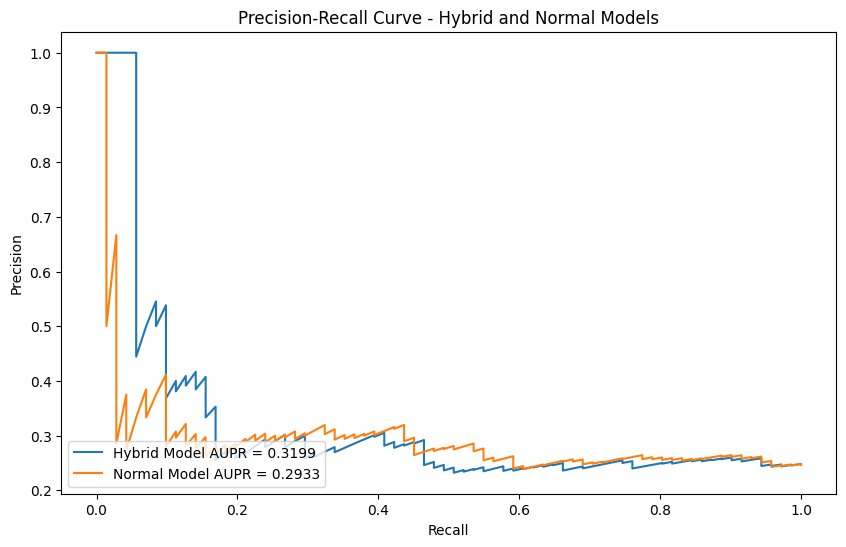

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_8932.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_8932.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)

### Testing Model From Seed 5

Hybrid Model Accuracy: 70.49%
Normal Model Accuracy: 65.62%
Hybrid Model F1 Score: 0.6762
Normal Model F1 Score: 0.6629
Hybrid Model AUC: 0.5738
Normal Model AUC: 0.5462


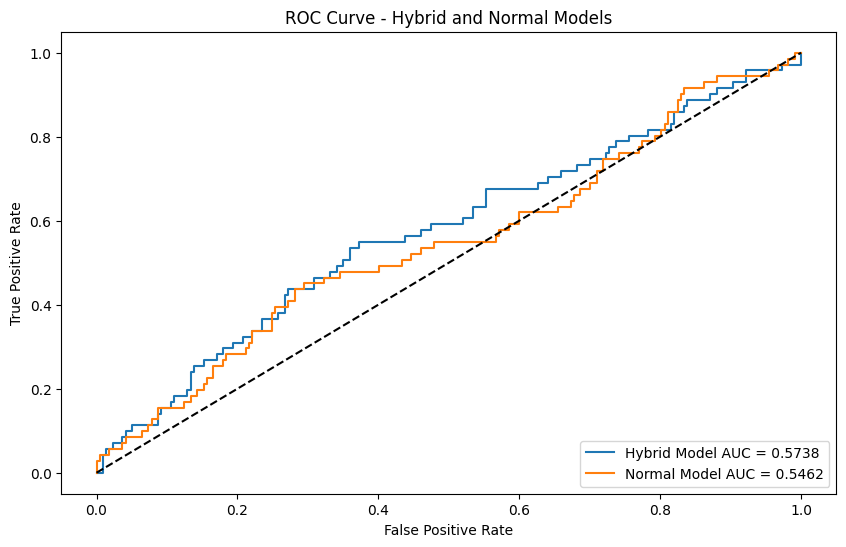

Hybrid Model AUPR: 0.3106
Normal Model AUPR: 0.3130


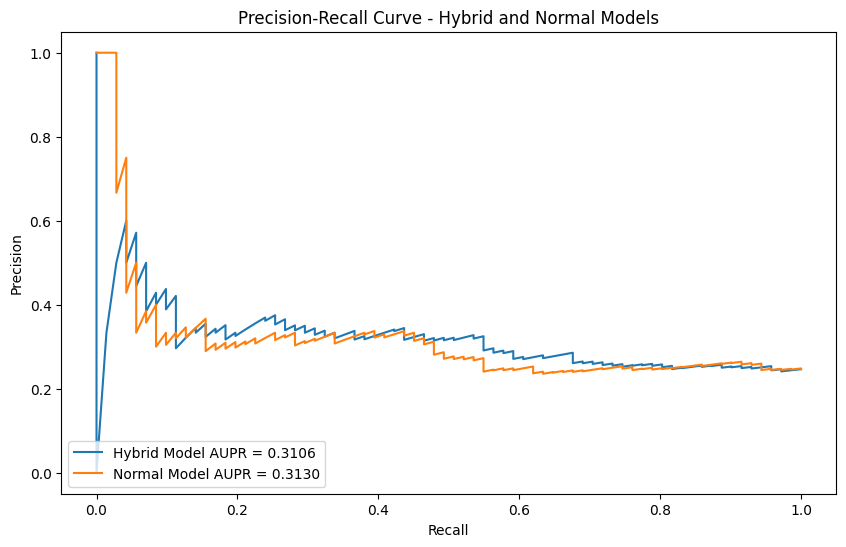

In [ ]:
model_normal = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/normal_model_5923.pth", weights_only=False)
model_hybrid = torch.load("/content/drive/MyDrive/OphAI-Harvard/QMLExperiments/PAPILA_models_2classes/quantum_hybrid_model_5923.pth", weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test(model_hybrid, model_normal, test_loader, num_classes)